In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.signal import spectrogram
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
class TTTEEGBlock(nn.Module):
    def __init__(self, hidden_size, num_heads=4, head_dim=None, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else hidden_size // num_heads
        self.eta = eta
        
        self.W1 = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim) * 0.02)
        self.b1 = nn.Parameter(torch.zeros(num_heads, 1, self.head_dim))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, cache_params=None):
        B, L, C = x.shape
        
        x = self.layer_norm(x)
        x = x.reshape(B, L, self.num_heads, self.head_dim)
        x = x.permute(0, 2, 1, 3)  # [B, H, L, D]
        
        if cache_params is None:
            output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, self.W1) + self.b1.unsqueeze(0))
        else:
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                output_temp = torch.einsum('bhld,hdf->bhlf', x_temp, self.W1) + self.b1.unsqueeze(0)
                
                # Self-supervised loss: L2 loss + consistency loss
                l2_loss = output_temp.pow(2).mean()
                consistency_loss = torch.abs(output_temp - x_temp.mean(dim=-1, keepdim=True)).mean()
                self_supervised_loss = l2_loss + 0.1 * consistency_loss
                
                # Compute gradients for self-supervised loss
                grads = torch.autograd.grad(self_supervised_loss, [self.W1, self.b1], retain_graph=True, create_graph=False)
                grad_W1, grad_b1 = grads
                
                grad_W1 = torch.clamp(grad_W1, -1.0, 1.0)
                grad_b1 = torch.clamp(grad_b1, -1.0, 1.0)
                
                if f'W1_states_{id(self)}' not in cache_params:
                    cache_params[f'W1_states_{id(self)}'] = self.W1.clone()
                    cache_params[f'b1_states_{id(self)}'] = self.b1.clone()
                    cache_params[f'momentum_W1_{id(self)}'] = torch.zeros_like(self.W1)
                    cache_params[f'momentum_b1_{id(self)}'] = torch.zeros_like(self.b1)
                
                momentum = 0.9
                cache_params[f'momentum_W1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_W1_{id(self)}'] + 
                    (1 - momentum) * grad_W1
                )
                cache_params[f'momentum_b1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_b1_{id(self)}'] + 
                    (1 - momentum) * grad_b1
                )
                
                cache_params[f'W1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_W1_{id(self)}']
                cache_params[f'b1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_b1_{id(self)}']
                
                output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, 
                                    cache_params[f'W1_states_{id(self)}']) + 
                                    cache_params[f'b1_states_{id(self)}'].unsqueeze(0))
        
        output = output.permute(0, 2, 1, 3)  # [B, L, H, D]
        output = output.reshape(B, L, -1)     # [B, L, H*D]
        
        return output + x.permute(0, 2, 1, 3).reshape(B, L, -1)  # Residual connection

In [4]:
# Load EEG data from .mat files
def load_mat_data(file_path):
    data = loadmat(file_path)['data'][0]
    inputs, targets = [], []
    map = {}
    current = 3
    for i in range(len(data)):
        y = data[i].flatten()
        sub = y[0][0]
        if y[1][0]=='letter-composing':
            continue
        if y[2][0] not in ['trial 1','trial 2','trial 3']:
            continue
        eeg_data = y[3][:6, :]
        if sub not in map:
            map[sub] = current
            current += 1
        targets.append(map[sub])
        inputs.append(eeg_data)
    return np.array(inputs), np.array(targets)

def preprocess_eeg(eeg_data):
    eeg_data = (eeg_data - np.mean(eeg_data)) / (np.std(eeg_data) + 1e-8)
    nyq = 0.5 * 256
    low, high = 0.5 / nyq, 45 / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, eeg_data)

# Load EEG data from folder structure
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        for i in range(6):
                            X.append(eeg_data[3750:6250, i])
                            y.append(subject_idx)
    return np.array(X), np.array(y)

# Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], 1))
    return x * factor


def create_spectrogram(eeg_data, fs=256, target_area=2500, num_frequencies=50, num_times=50):   
    # Calculate the segment length (nperseg) based on the desired number of frequency bins
    # The formula for frequency bins is: number of bins = nperseg / 2 + 1
    required_nperseg = (num_frequencies - 1) * 2  # Desired frequency bins and corresponding nperseg

    # Ensure nperseg doesn't exceed the total signal length
    nperseg = min(required_nperseg, len(eeg_data))

    noverlap = nperseg // 2  # Overlap (half of segment length by default)

    # Compute the spectrogram
    frequencies, times, Sxx = spectrogram(
        eeg_data, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, detrend='constant', scaling='density'
    )

    # Ensure we get the expected number of frequency bins
    if Sxx.shape[0] < num_frequencies:
        print(f"Warning: Expected {num_frequencies} frequency bins, but got {Sxx.shape[0]}. Padding with zeros.")
        padding = num_frequencies - Sxx.shape[0]
        Sxx = np.pad(Sxx, ((0, padding), (0, 0)), mode='constant')
    elif Sxx.shape[0] > num_frequencies:
        # If the number of frequency bins is more than desired, truncate
        Sxx = Sxx[:num_frequencies, :]

    # Ensure the number of time bins matches the desired number
    if Sxx.shape[1] < num_times:
        padding = num_times - Sxx.shape[1]
        Sxx = np.pad(Sxx, ((0, 0), (0, padding)), mode='constant')
    elif Sxx.shape[1] > num_times:
        # Trim time bins if there are more than desired
        Sxx = Sxx[:, :num_times]

    # Convert to decibels
    Sxx = 10 * np.log10(Sxx + 1e-5)

    # Normalize the spectrogram
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)
    return Sxx

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class TTTCell(nn.Module):
    def __init__(self, input_size, hidden_size, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.eta = eta
        
        # Hidden state model (f in the paper)
        self.hidden_model = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # Initialize cache for test-time updates
        self.cache_params = {}
        
    def forward(self, x, hidden, is_training=True):
        if is_training:
            next_hidden = self.hidden_model(x)
        else:
            # Test-time training update
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                pred = self.hidden_model(x_temp)
                
                # Self-supervised loss (as described in paper section 2.1)
                l2_loss = pred.pow(2).mean()
                consistency_loss = torch.abs(pred - x_temp.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Update hidden model parameters
                grads = torch.autograd.grad(loss, self.hidden_model.parameters())
                
                with torch.no_grad():
                    for param, grad in zip(self.hidden_model.parameters(), grads):
                        if f'momentum_{id(param)}' not in self.cache_params:
                            self.cache_params[f'momentum_{id(param)}'] = torch.zeros_like(param)
                        
                        # Momentum update
                        self.cache_params[f'momentum_{id(param)}'].mul_(0.9).add_(grad, alpha=0.1)
                        param.add_(self.cache_params[f'momentum_{id(param)}'], alpha=-self.eta)
                
                next_hidden = self.hidden_model(x)
                
        return next_hidden


class TTTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create TTT cells for each layer
        self.cells = nn.ModuleList([
            TTTCell(
                input_size if i == 0 else hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])
    
    def forward(self, x, hidden=None, is_training=True):
        batch_size, seq_len, _ = x.shape
        
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size).to(x.device)
                     for _ in range(self.num_layers)]
        
        outputs = []
        for t in range(seq_len):
            layer_input = x[:, t, :]
            for layer_idx, cell in enumerate(self.cells):
                hidden[layer_idx] = cell(layer_input, hidden[layer_idx], is_training)
                layer_input = hidden[layer_idx]
            outputs.append(layer_input)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden


class EEGClassifier(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.cache_params = {}
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            # Initial block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 25x25
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6
            
            # Fourth block with global pooling
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to 1x1
        )
        
        # TTT blocks
        self.ttt_blocks = nn.ModuleList([
            TTTEEGBlock(hidden_size=256, num_heads=4)
            for _ in range(2)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),  # Now using 256 features from global pooling
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        
        # Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),  # From 256 features
            nn.ReLU(),
            nn.Linear(1024, 50 * 50)
        )
    
    def forward(self, x):
        # Print input shape for debugging
        # print("Input shape:", x.shape)
        
        # Ensure input shape [B, C, H, W]
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Extract features
        features = self.feature_extractor(x)  # [B, 256, 1, 1]
        # print("After feature extractor:", features.shape)
        
        # Reshape for TTT blocks
        features = features.squeeze(-1).squeeze(-1)  # [B, 256]
        features = features.unsqueeze(1)  # [B, 1, 256]
        
        # Apply TTT blocks
        for block in self.ttt_blocks:
            features = block(features, self.cache_params)
        
        # Prepare for classification
        features = features.squeeze(1)  # [B, 256]
        
        # Classification
        logits = self.classifier(features)
        
        # Reconstruction
        recon = self.decoder(features)
        recon = recon.view(-1, 1, 50, 50)
        
        return logits, recon
    
def SEBlock(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(channels, channels, kernel_size=1),
        nn.Sigmoid()
    )


def ResidualBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.GELU(),
        SEBlock(out_channels),
    )

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_val_acc = 0
    patience = 7
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.float()
            
            optimizer.zero_grad(set_to_none=True)
            
            try:
                # Forward pass
                outputs, recon = model(inputs)
                
                # Calculate losses
                ce_loss = criterion(outputs, labels)
                recon_loss = F.mse_loss(recon, inputs)
                loss = ce_loss + 0.1 * recon_loss
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                # Update metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Update progress bar
                accuracy = 100. * correct / total
                pbar.set_postfix({
                    'loss': f'{running_loss/(batch_idx+1):.4f}',
                    'acc': f'{accuracy:.2f}%'
                })
                
            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {e}")
                print(f"Input shape: {inputs.shape}")
                raise e
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float()
                outputs, _ = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        print(f'\nValidation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_accuracy,
            }, 'best_model.pth')
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print(f'Early stopping triggered. Best validation accuracy: {best_val_acc:.2f}%')
        #         checkpoint = torch.load('best_model.pth')
        #         model.load_state_dict(checkpoint['model_state_dict'])
        #         break
    
    return model

# Test-time adaptation function
def test_time_adaptation(model, test_loader, adaptation_steps=5, adaptation_lr=0.001):
    model.eval()
    inner_optimizer = optim.SGD(model.inner_model.parameters(), lr=adaptation_lr)
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        for _ in range(adaptation_steps):
            inner_optimizer.zero_grad()
            _, recon = model(inputs)
            inputs = inputs.squeeze(2)
            recon_loss = nn.functional.mse_loss(recon, inputs)
            inputs = inputs.unsqueeze(2)
            recon_loss.backward()
            inner_optimizer.step()
    return model

In [7]:
class EEGDataset(Dataset):
    def __init__(self, data, labels, augment=False):
        self.data = []
        self.labels = []
        
        for i, eeg in enumerate(tqdm(data, desc="Creating spectrograms")):
            for channel in range(eeg.shape[0]):
                spectrogram = create_spectrogram(preprocess_eeg(eeg[channel]))
                if augment:
                    # Add more augmentations
                    specs = [
                        spectrogram,
                        jitter(spectrogram, sigma=0.01),
                        scaling(spectrogram, sigma=0.1),
                        add_noise(spectrogram, noise_level=0.01),
                        time_warp(spectrogram, sigma=2)
                    ]
                    for spec in specs:
                        self.data.append(spec)
                        self.labels.append(labels[i])
                else:
                    self.data.append(spectrogram)
                    self.labels.append(labels[i])
        
        self.data = torch.FloatTensor(np.stack(self.data))
        self.data = self.data.unsqueeze(1)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def add_noise(x, noise_level=0.01):
    return x + np.random.randn(*x.shape) * noise_level

def time_warp(x, sigma=2):
    """Apply time warping to a 2D spectrogram."""
    x = np.array(x)
    if len(x.shape) != 2:
        raise ValueError(f"Expected 2D input, got shape {x.shape}")
        
    time_steps = np.arange(x.shape[1])
    # Generate random warping
    warp = np.random.normal(loc=1.0, scale=sigma, size=(1,))
    warp_steps = time_steps * warp
    
    # Ensure warp_steps are within bounds
    warp_steps = np.clip(warp_steps, 0, x.shape[1]-1)
    
    # Apply warping to each frequency bin
    warped = np.zeros_like(x)
    for i in range(x.shape[0]):
        warped[i, :] = np.interp(time_steps, warp_steps, x[i, :])
    
    return warped

def jitter(x, sigma=0.01):
    """Add random jitter noise."""
    return x + np.random.normal(0, sigma, x.shape)

def scaling(x, sigma=0.1):
    """Apply random scaling."""
    factor = np.random.normal(1.0, sigma)
    return x * factor

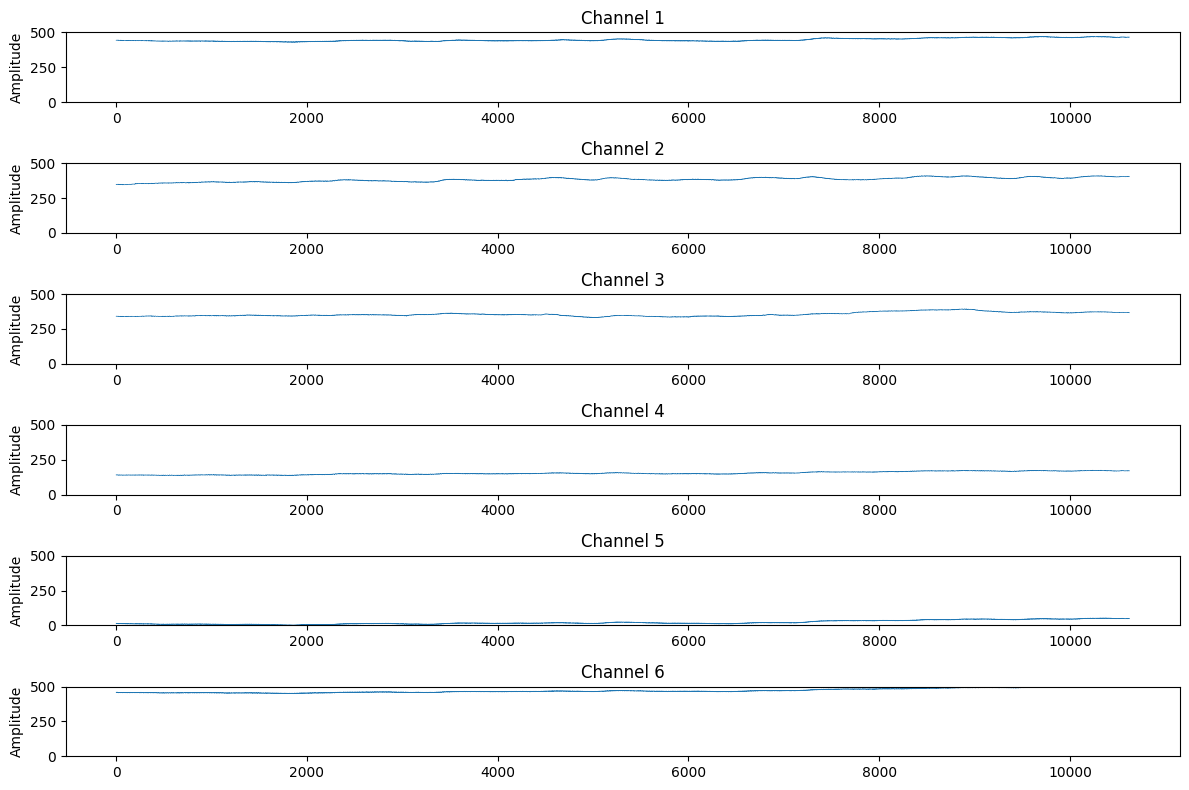

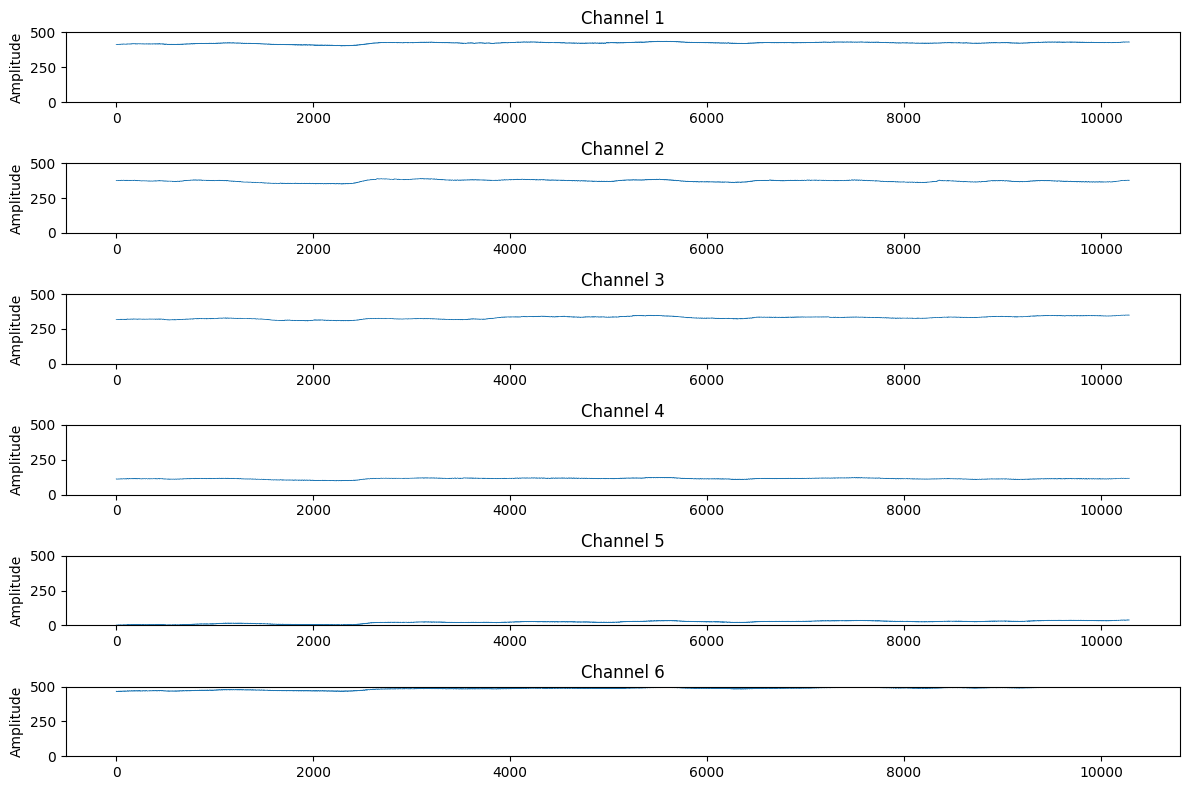

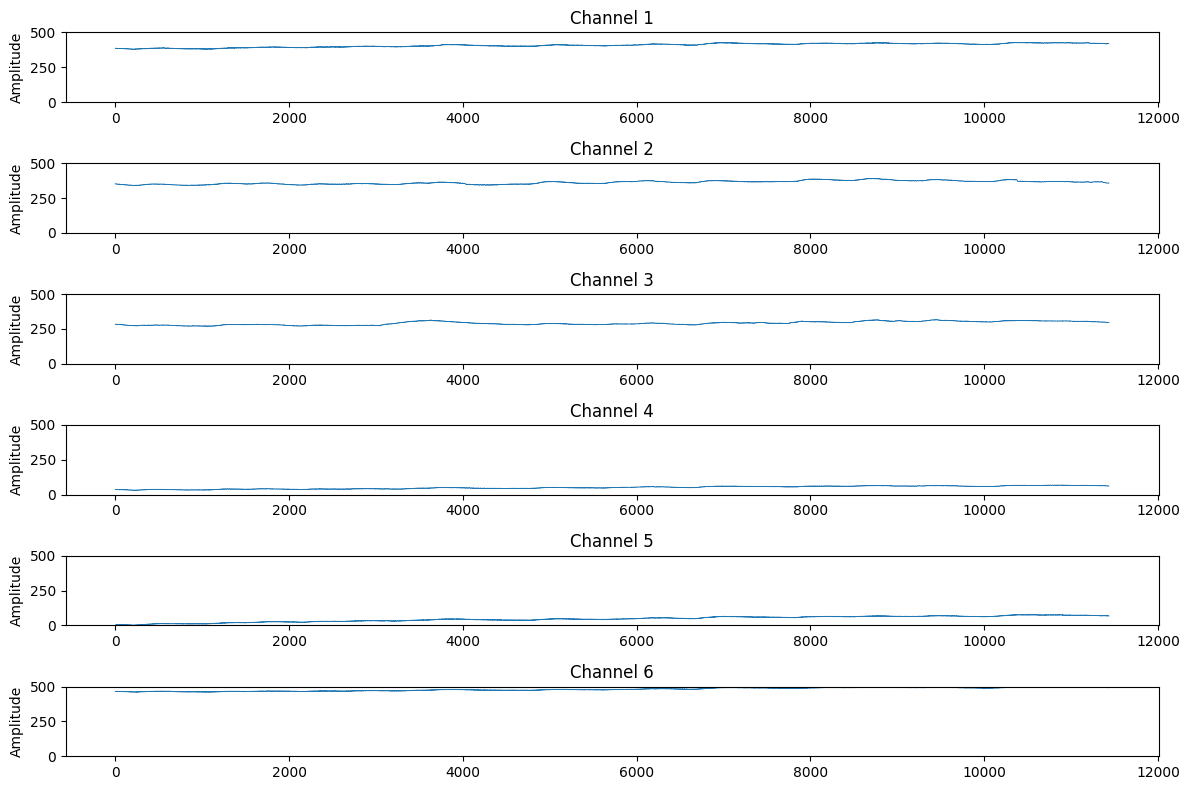

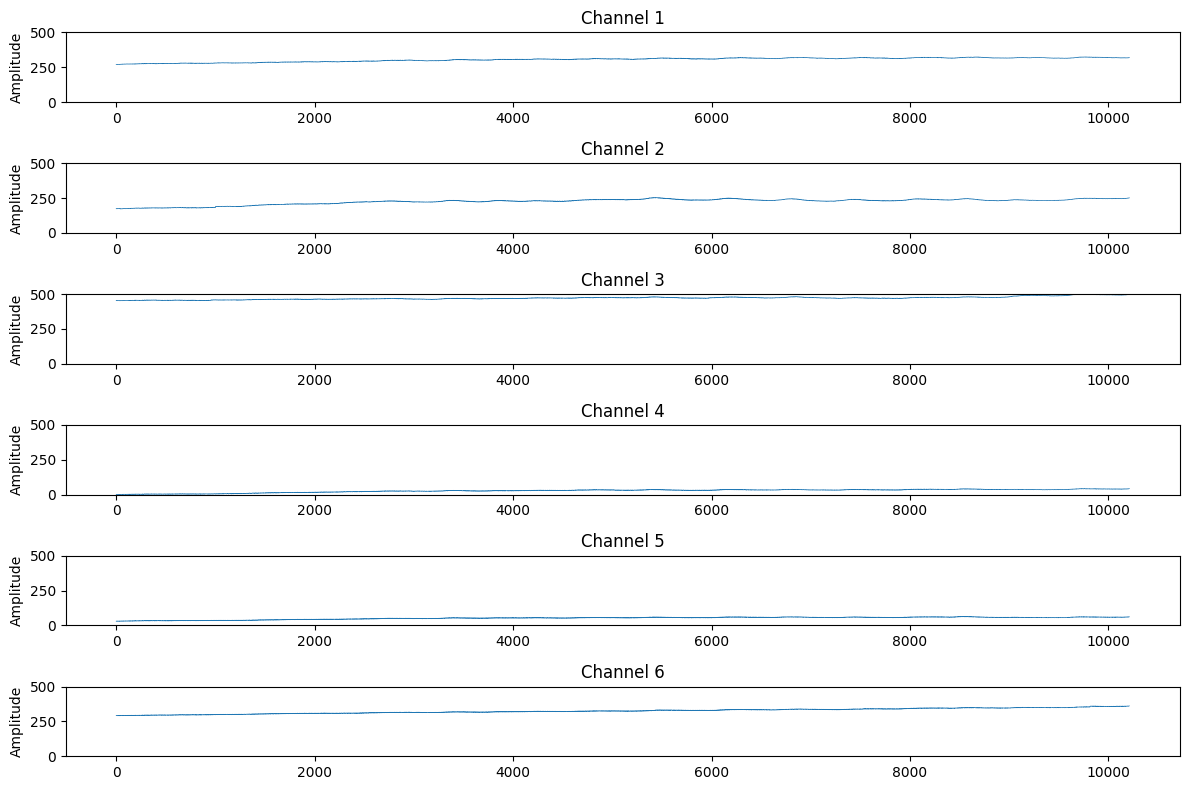

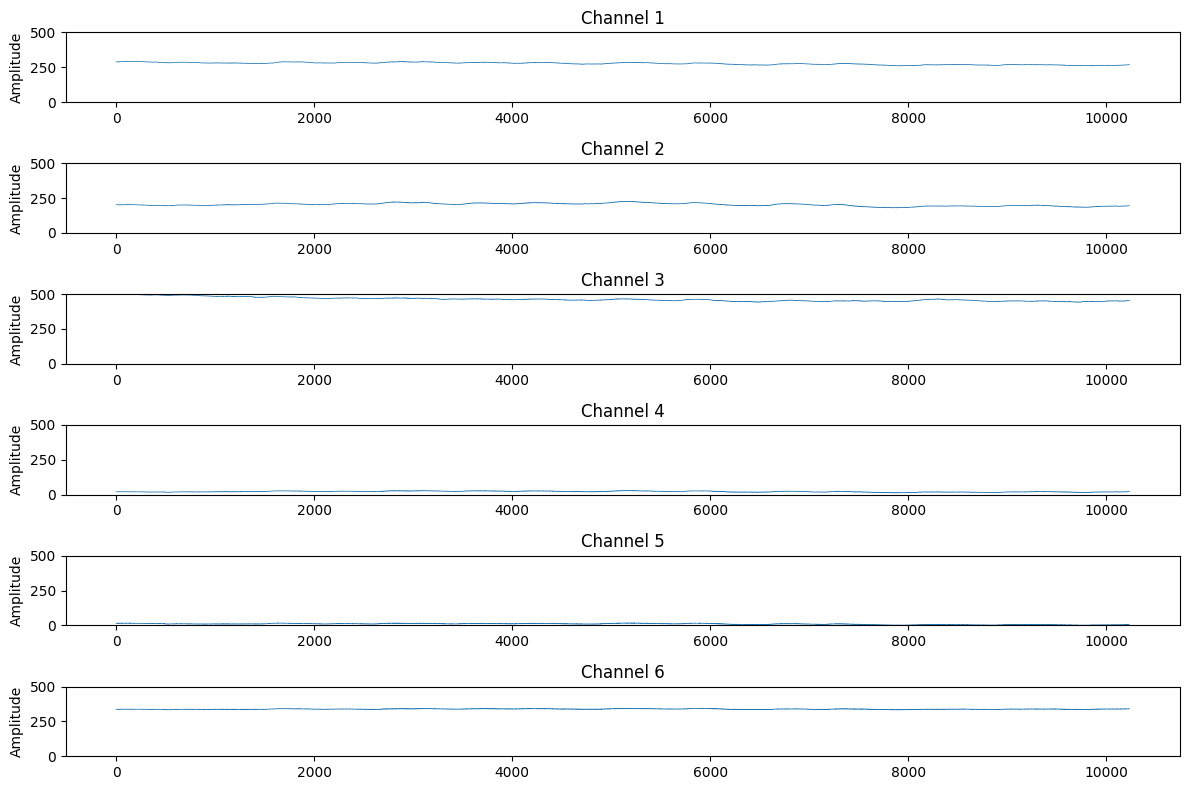

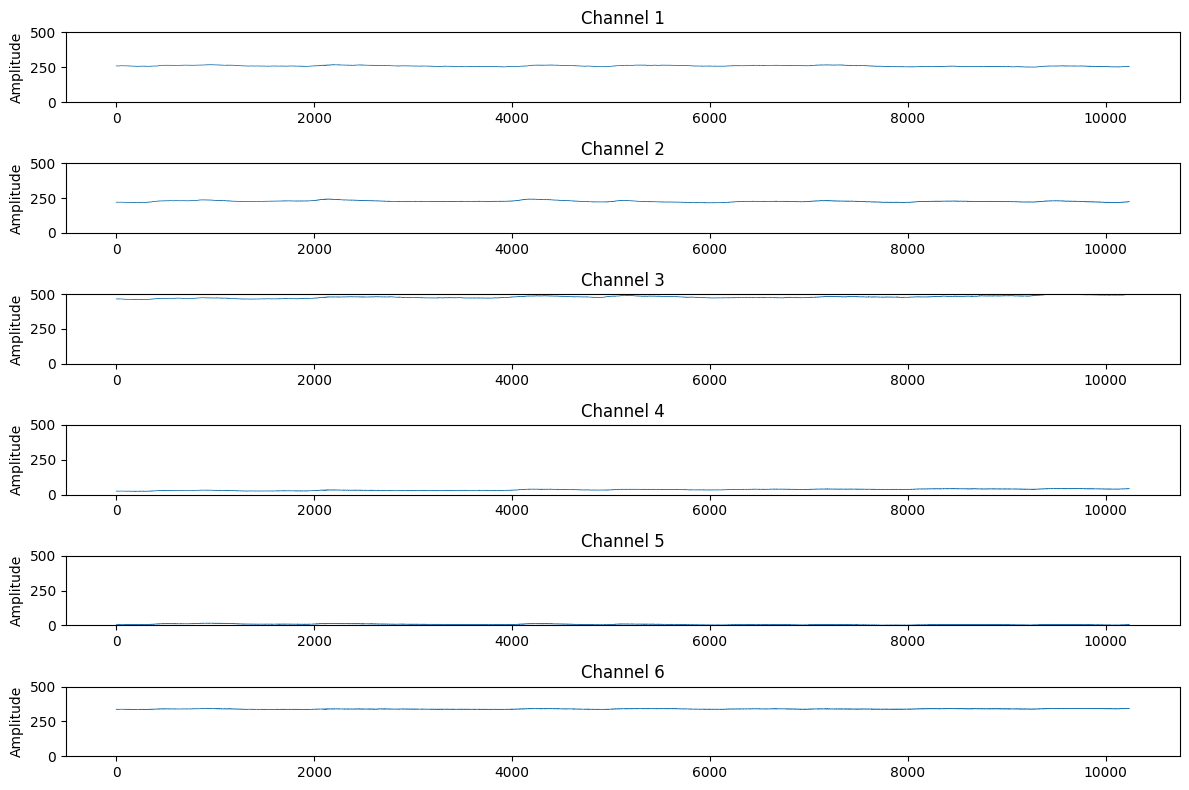

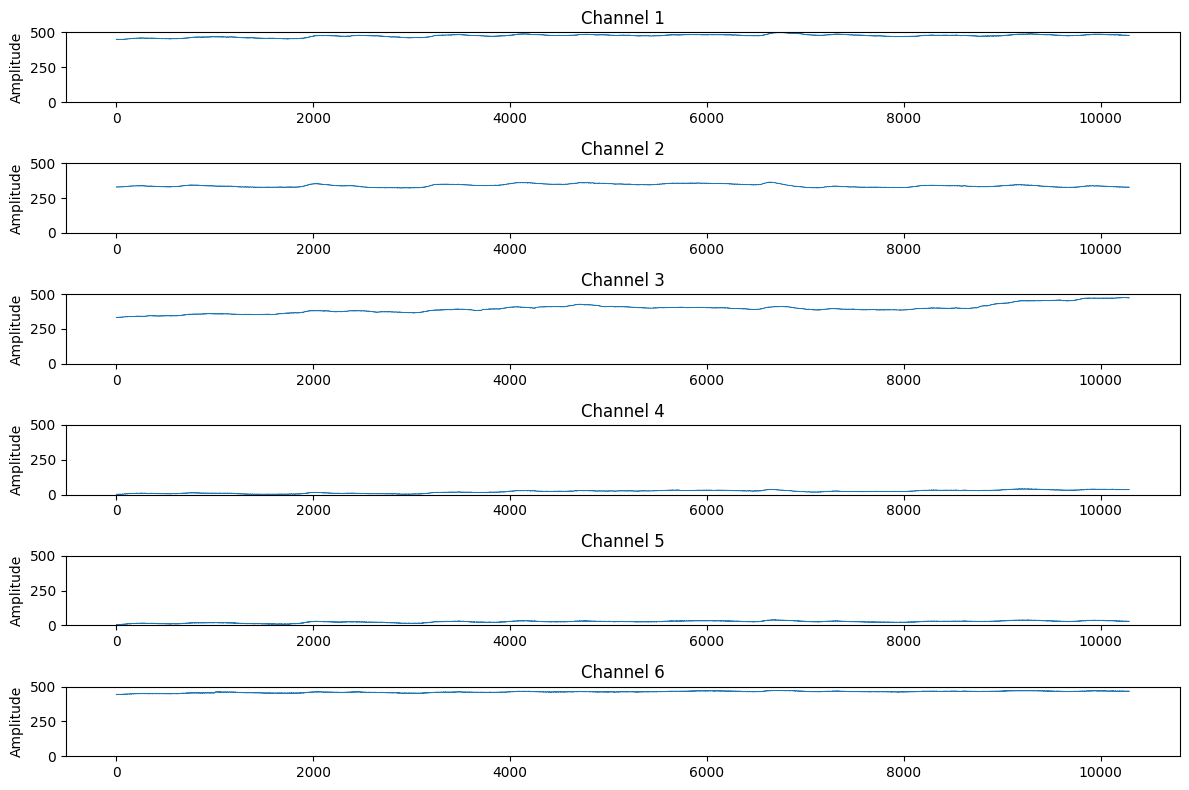

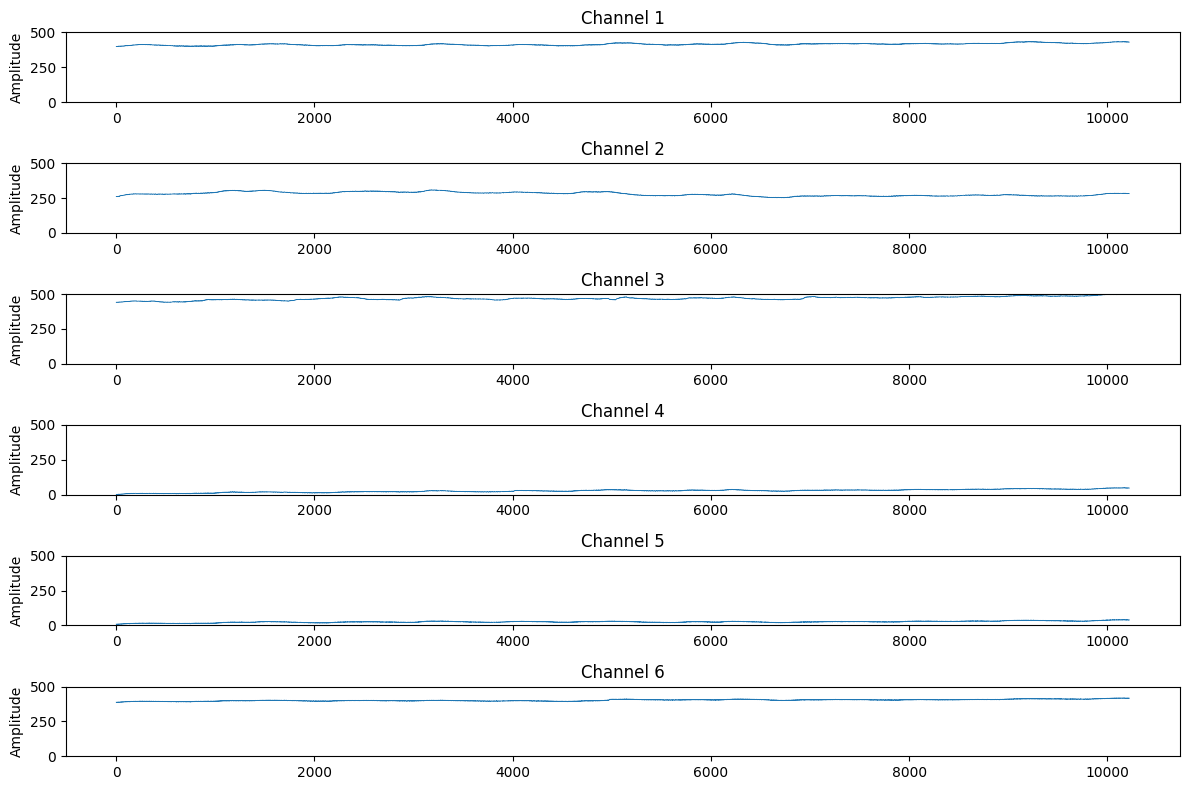

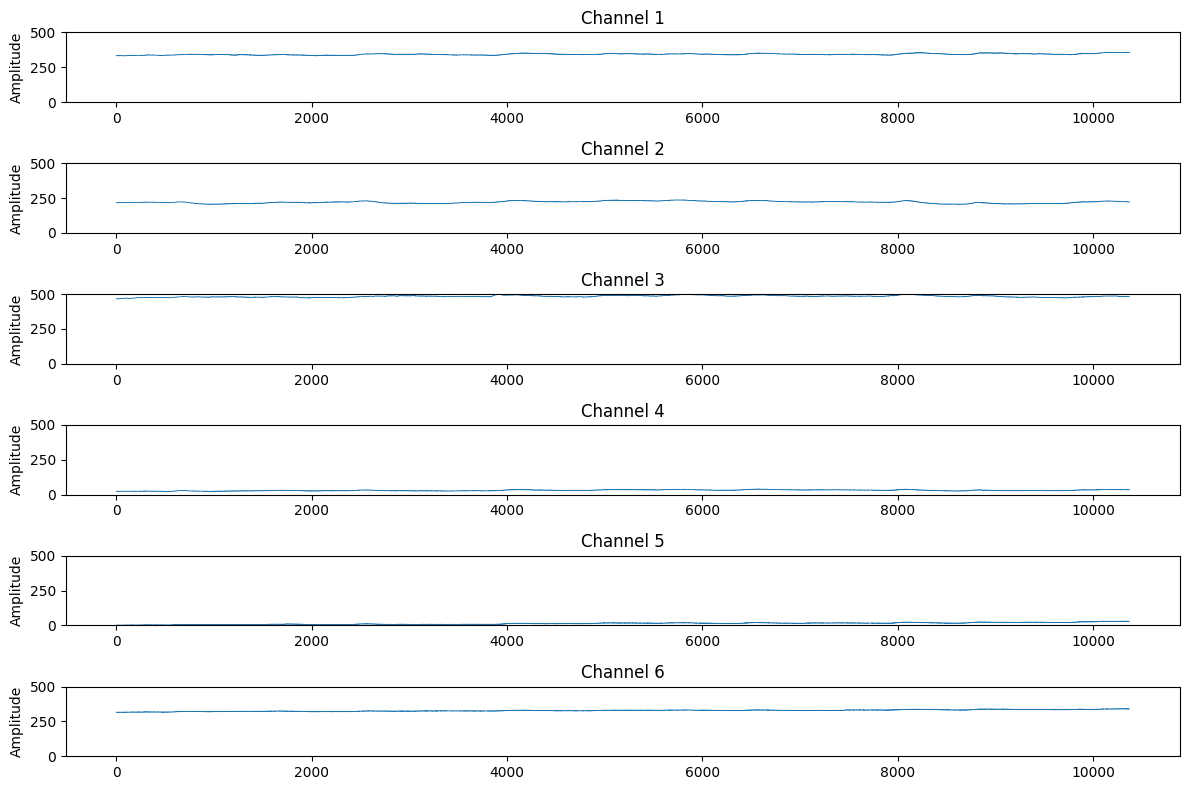

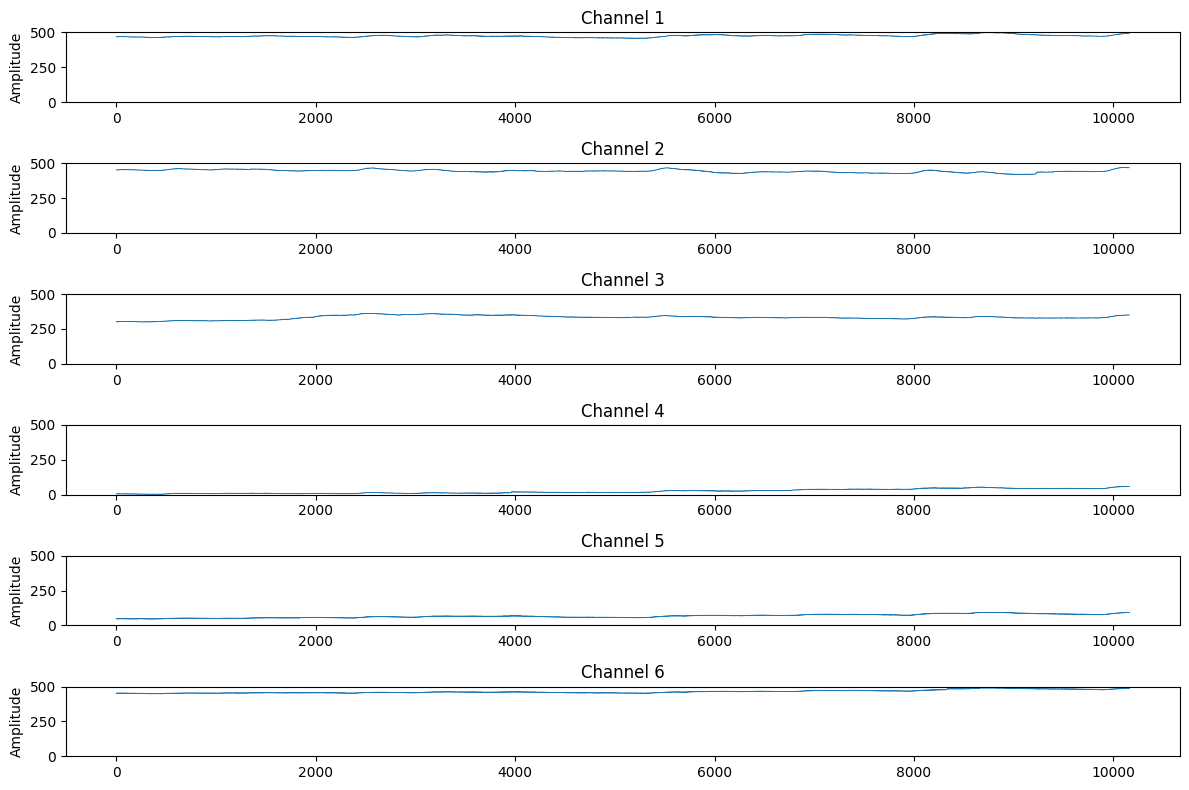

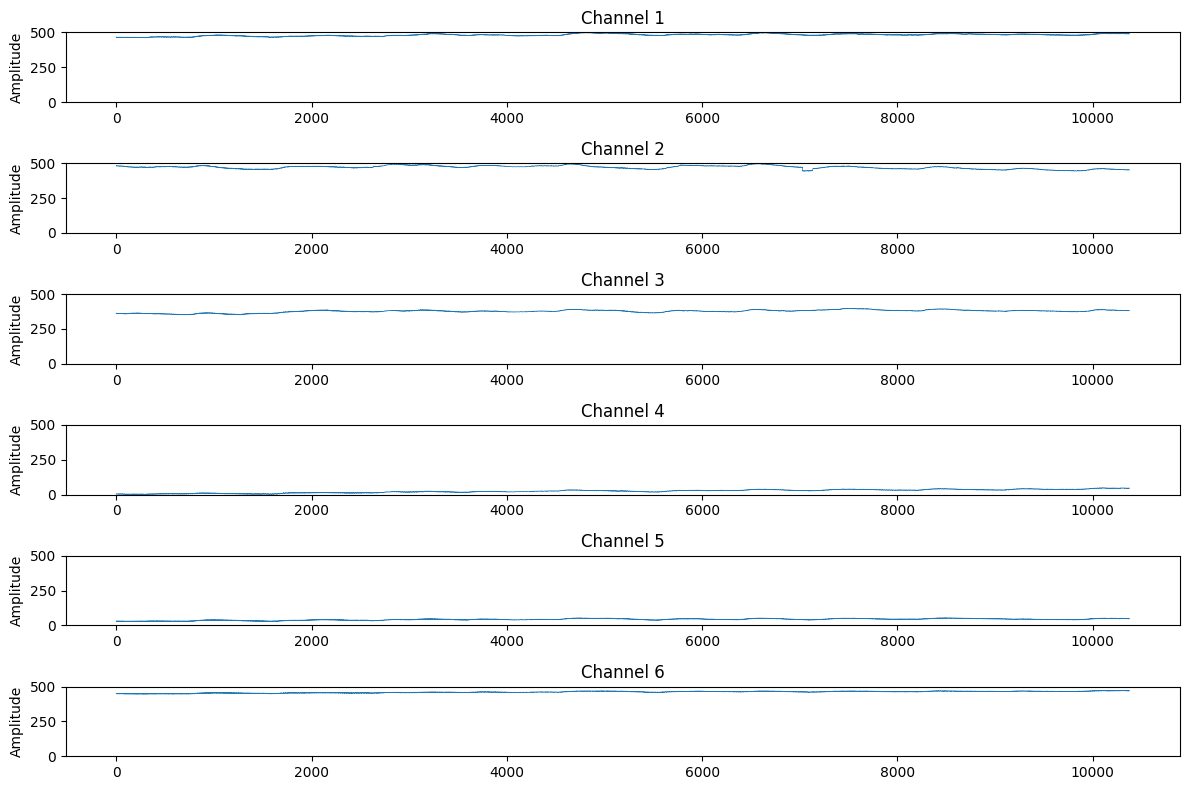

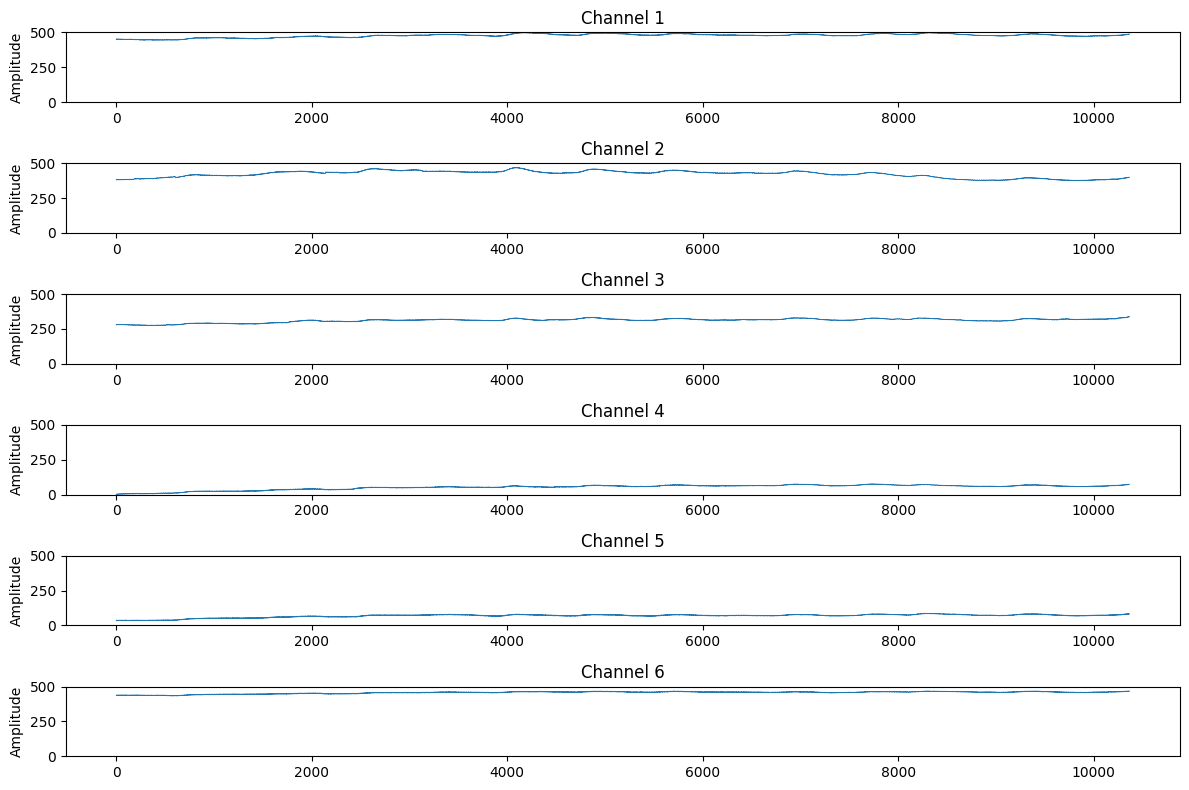

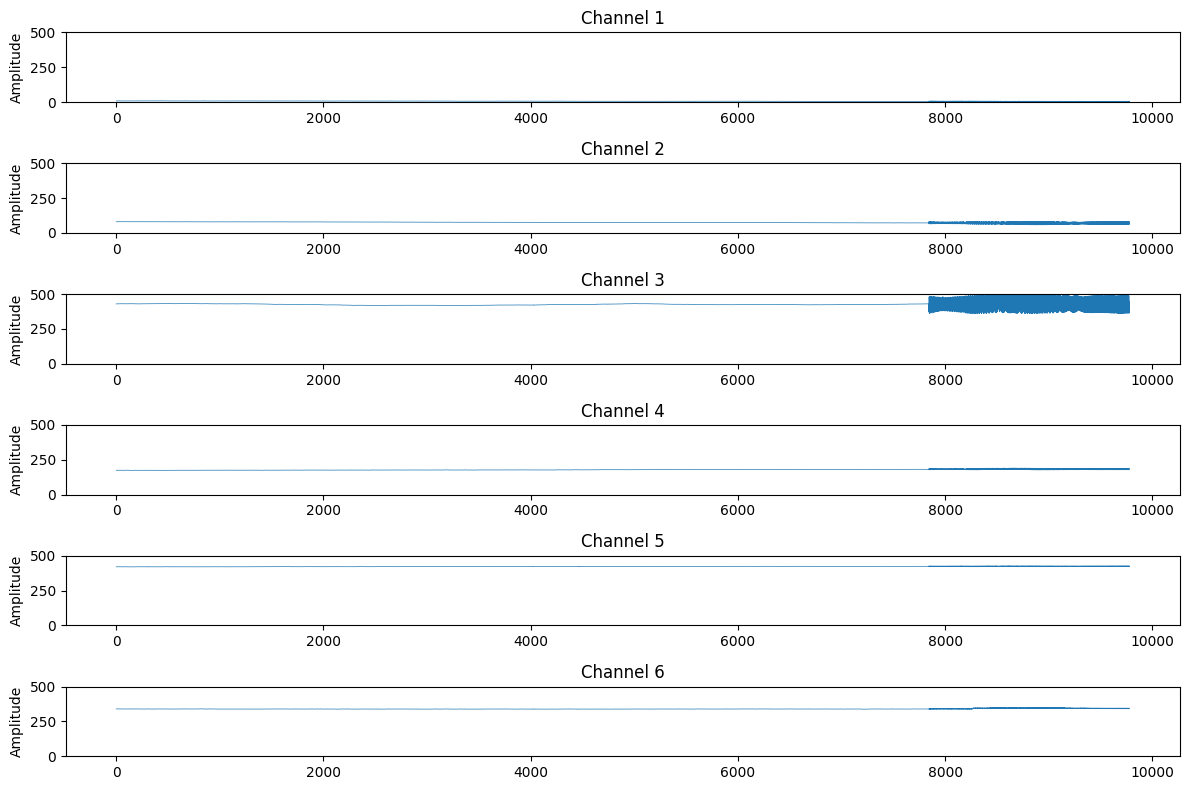

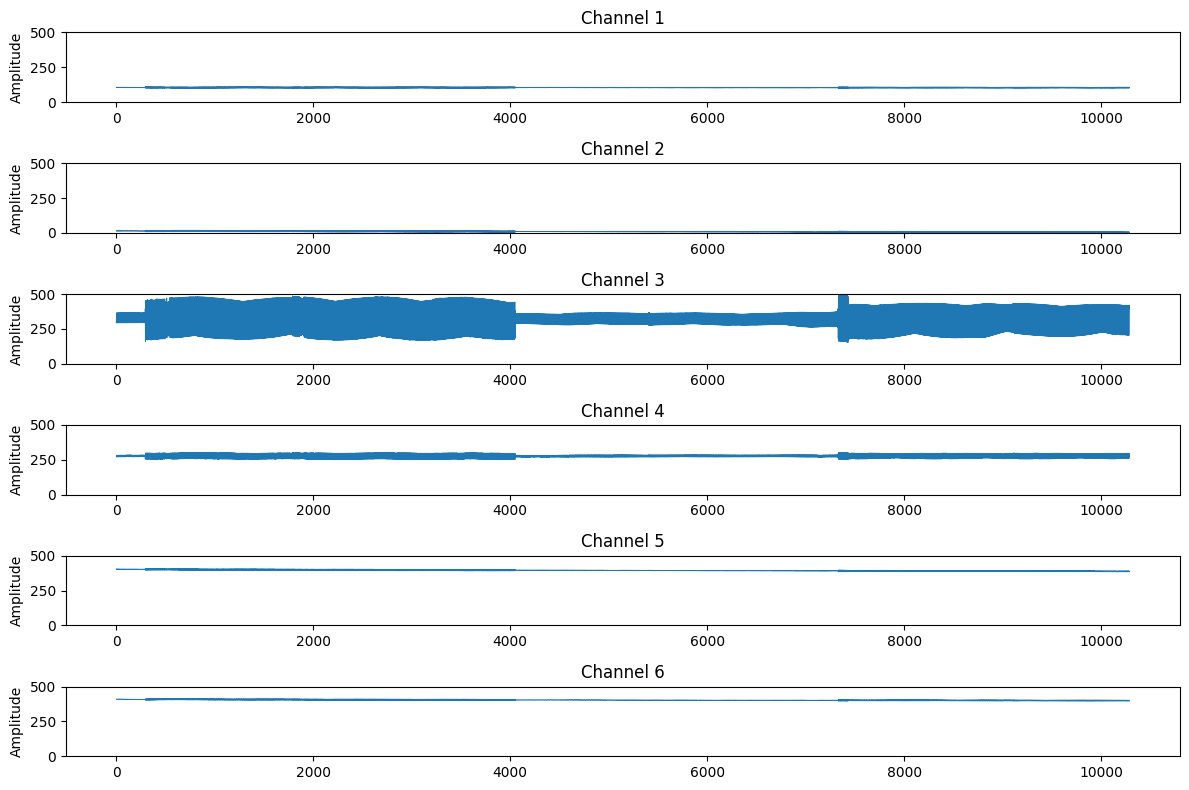

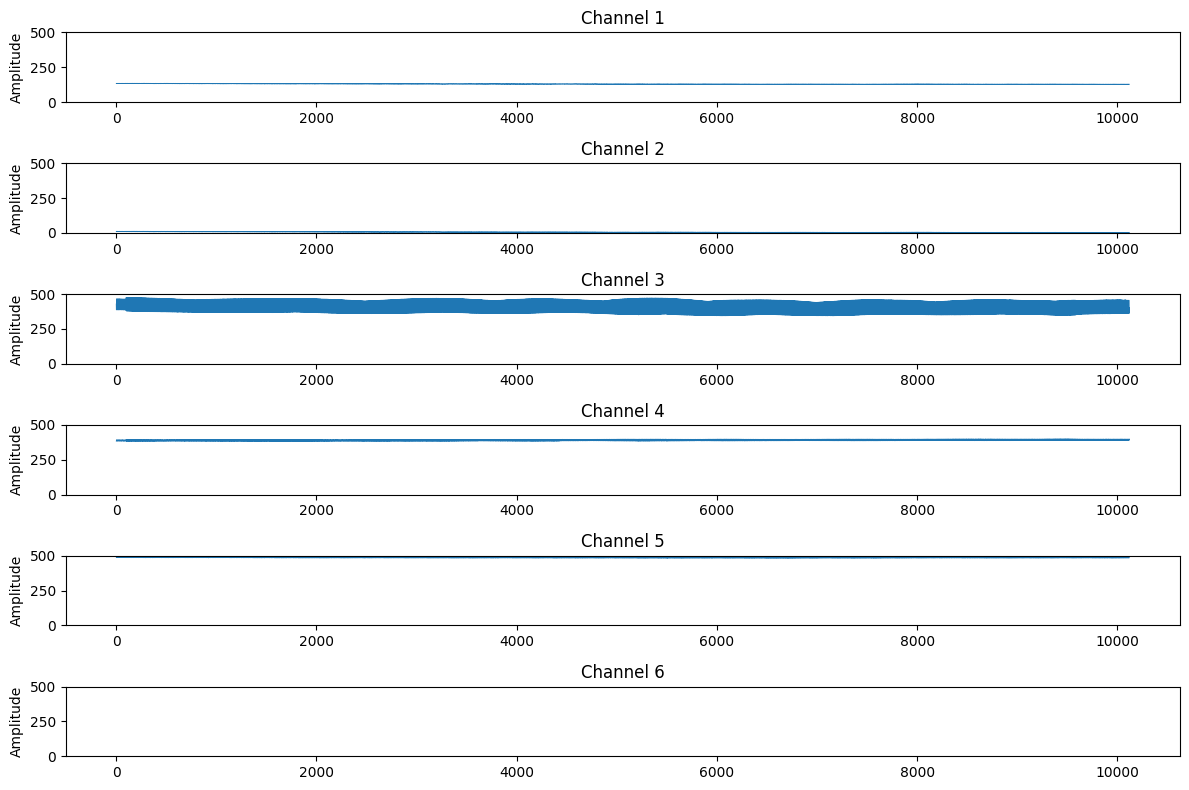

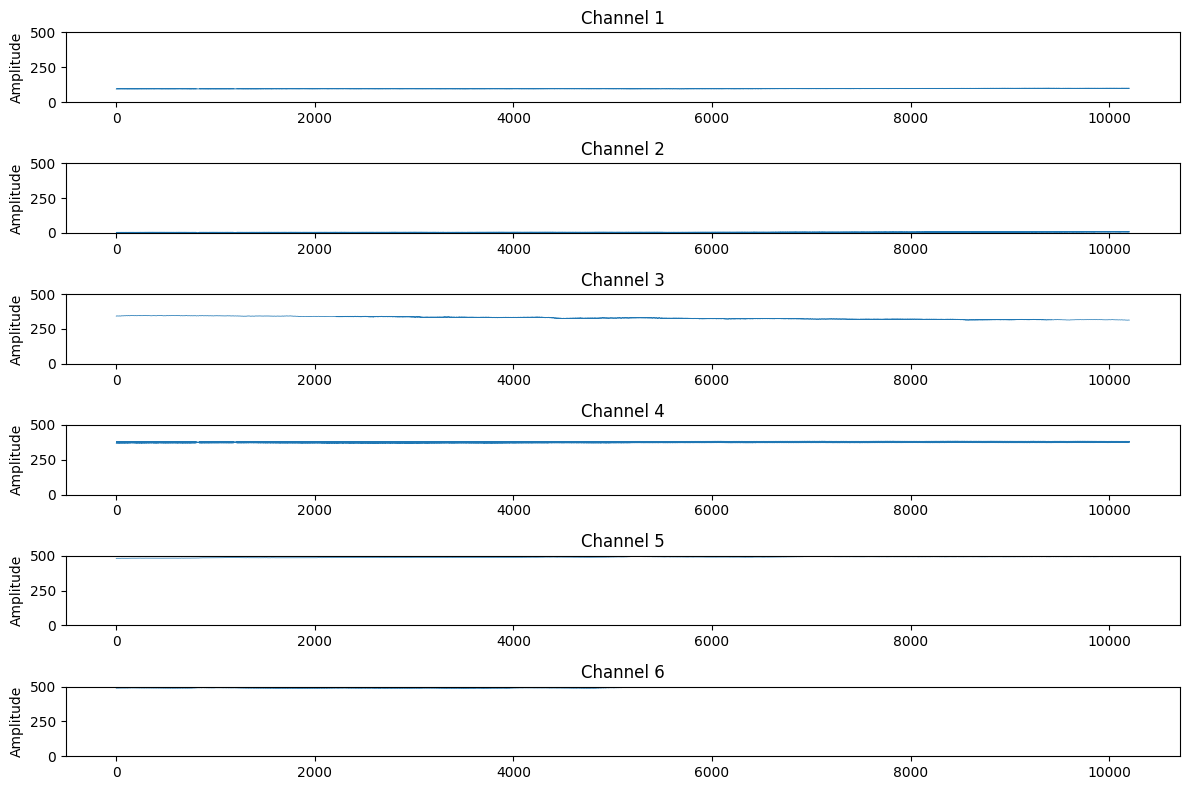

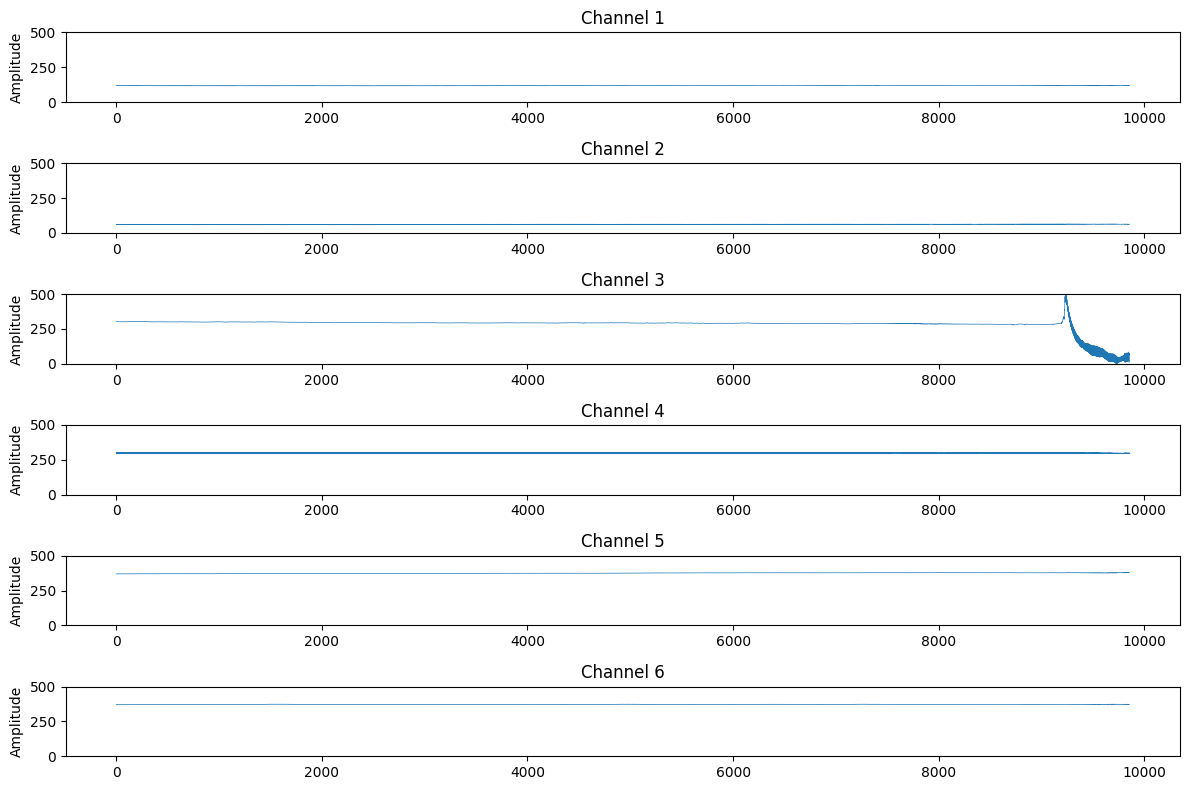

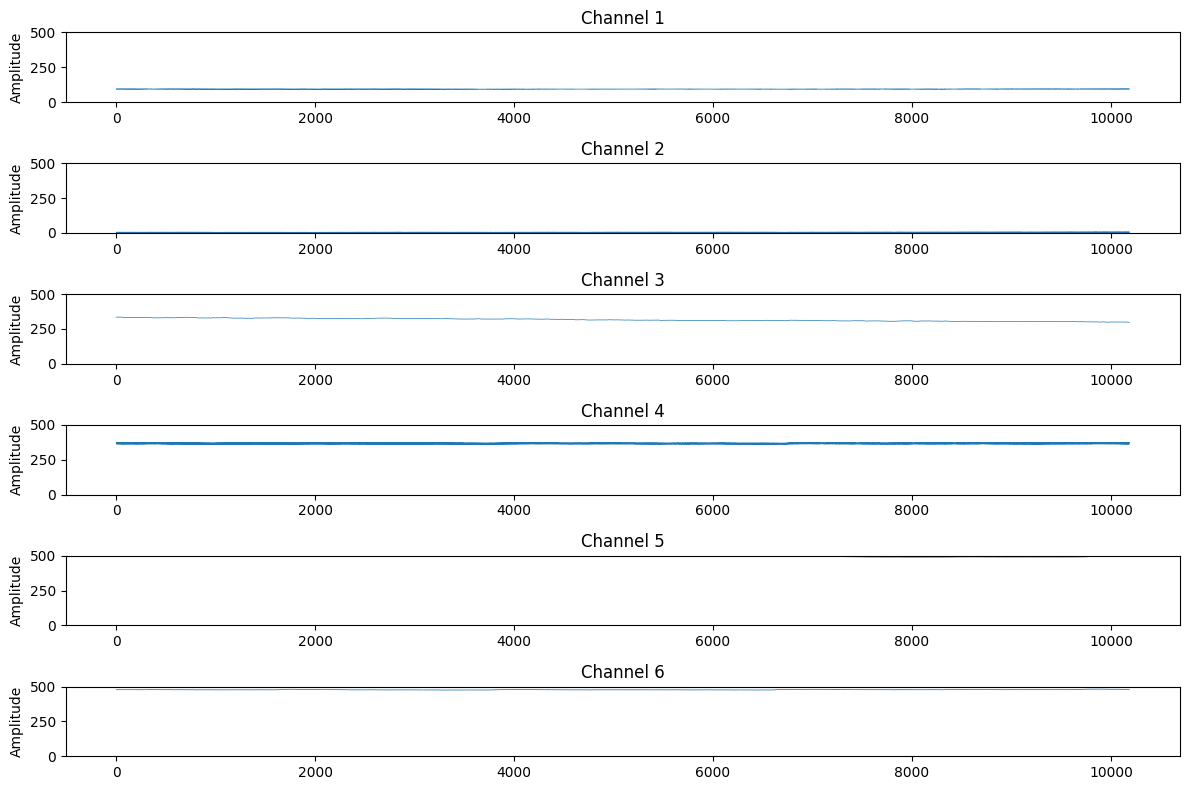

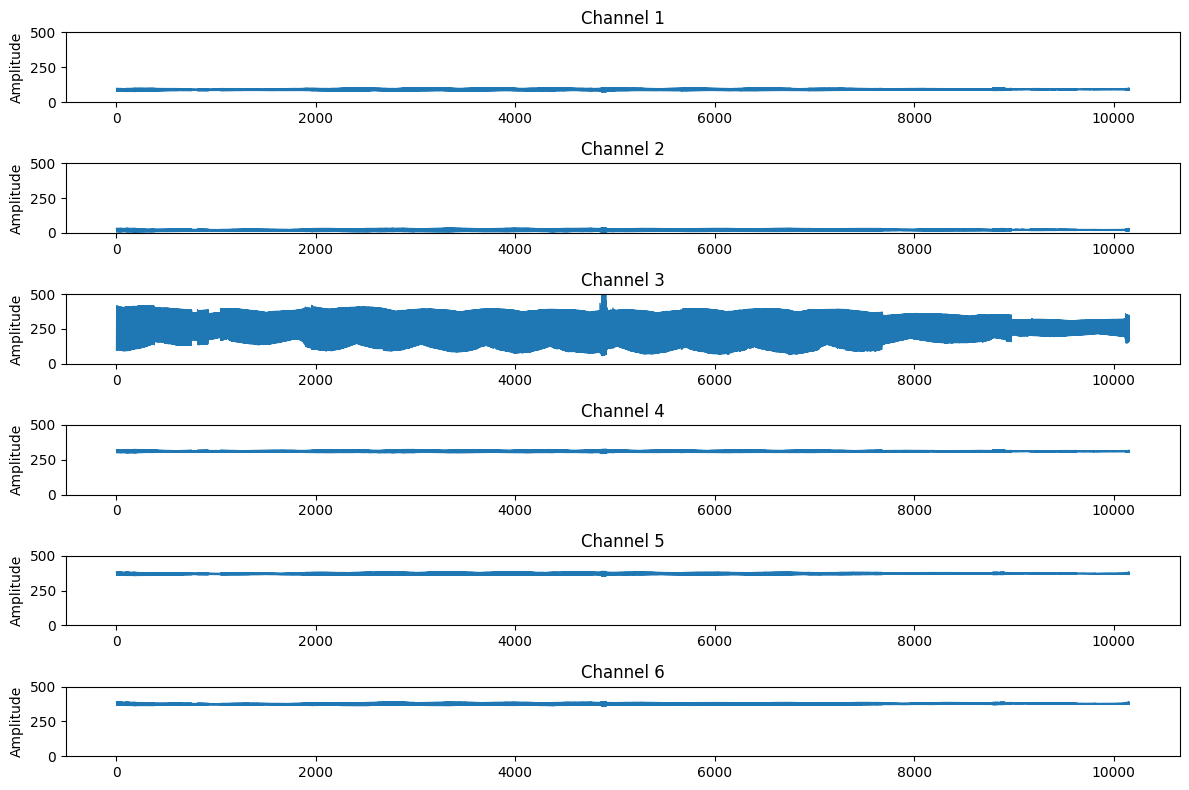

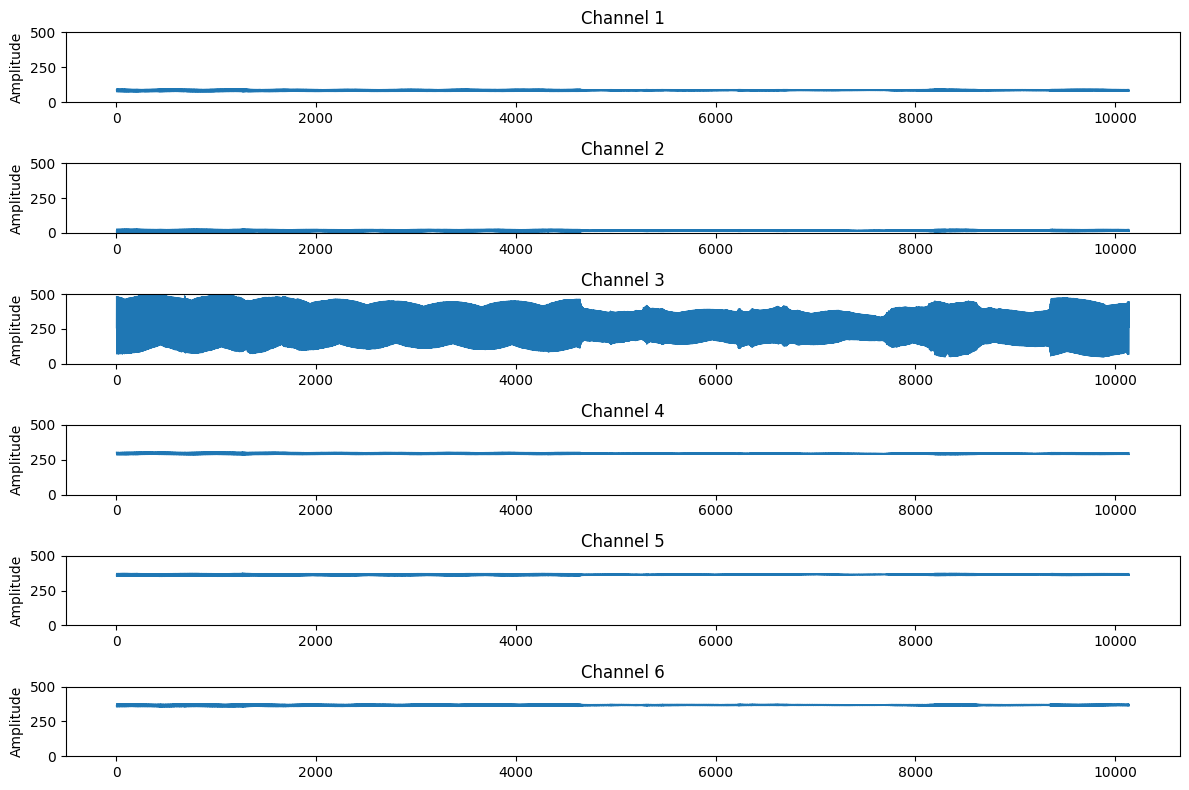

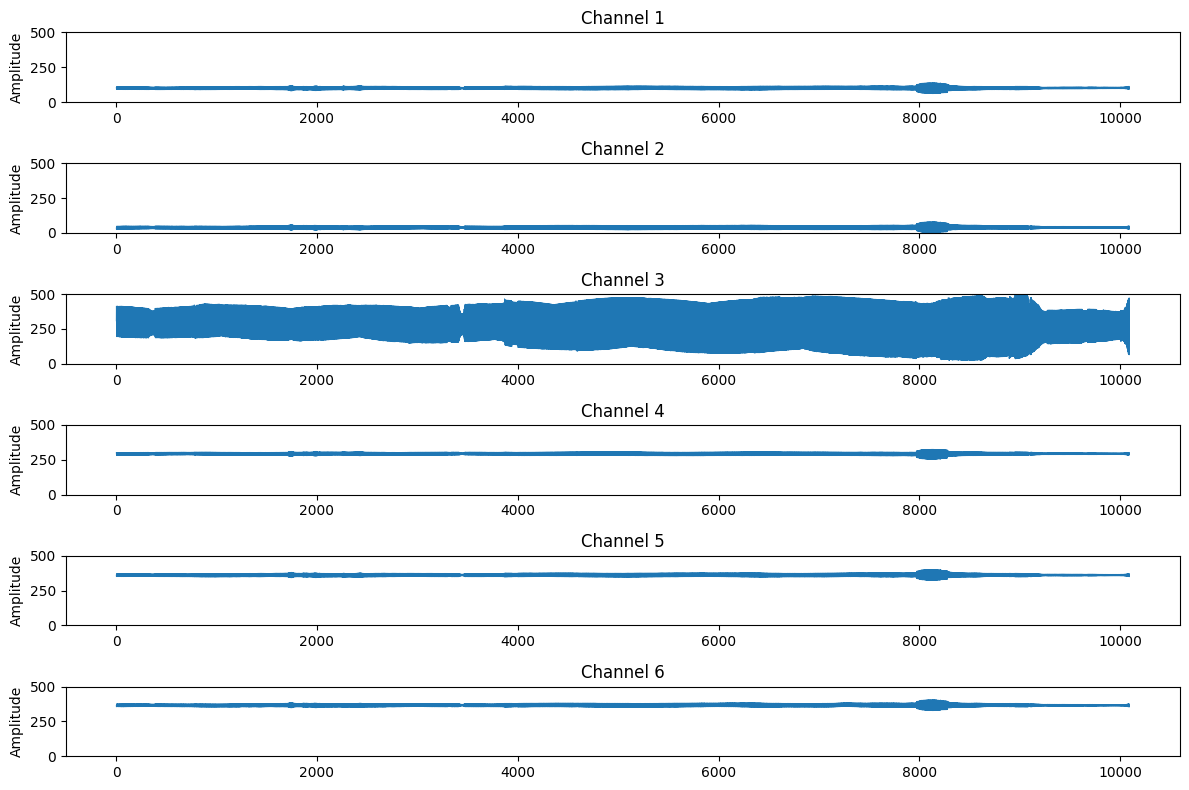

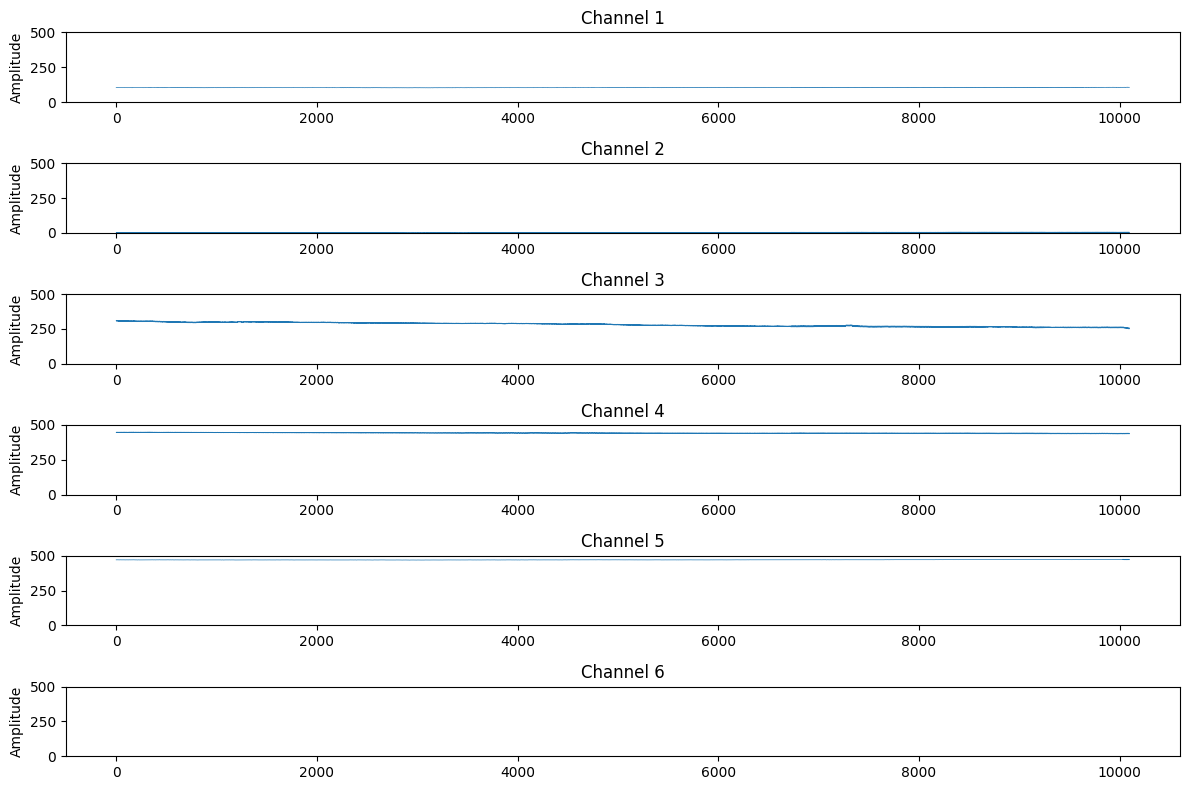

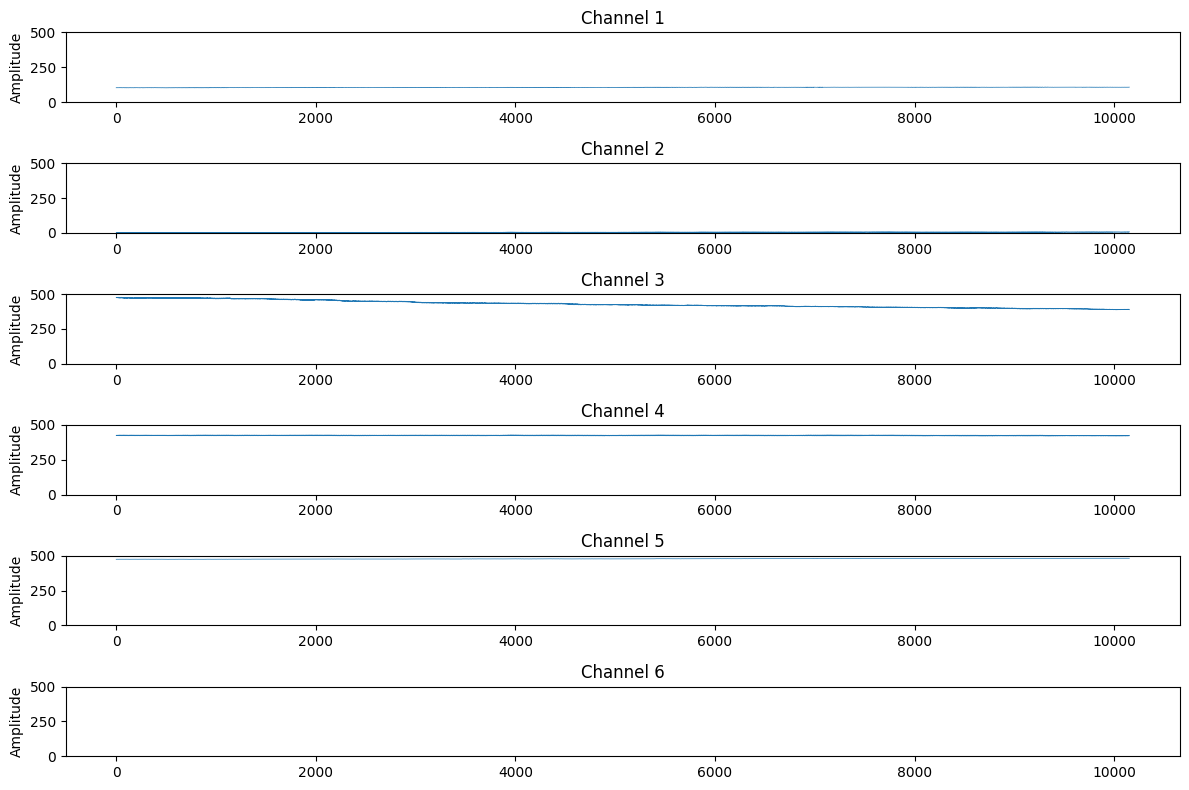

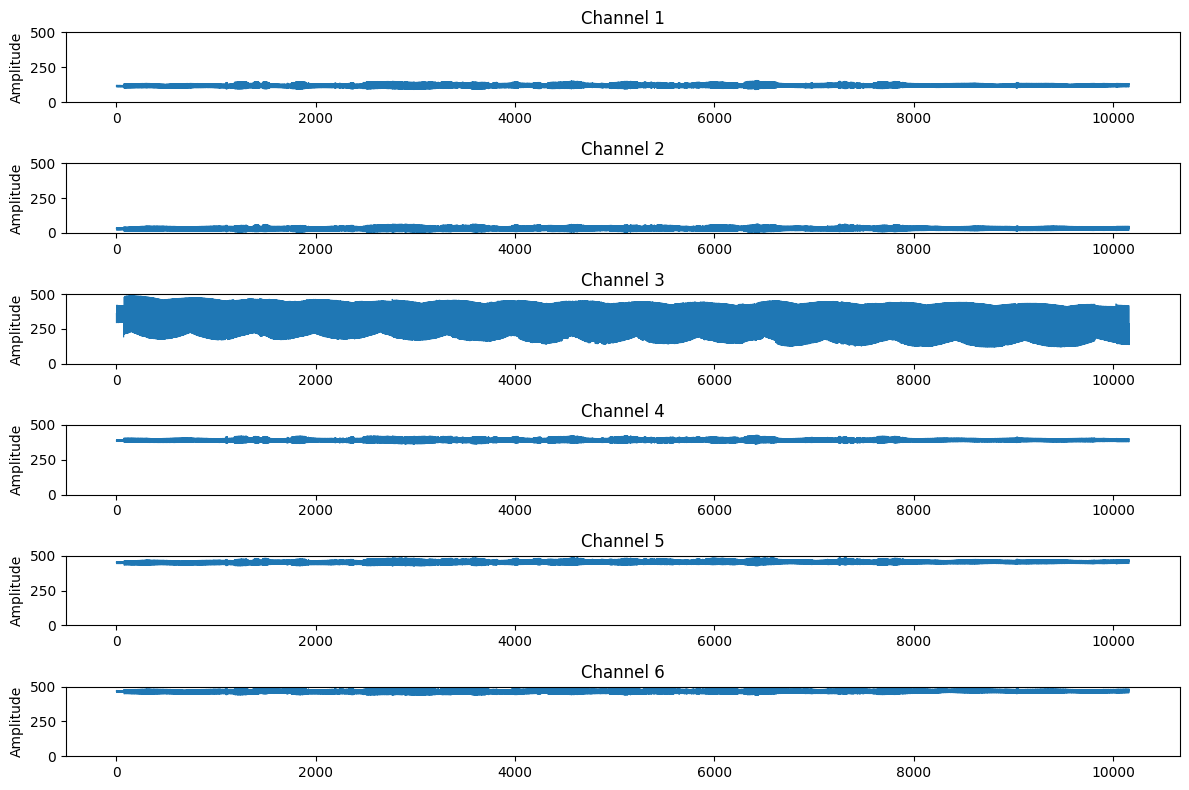

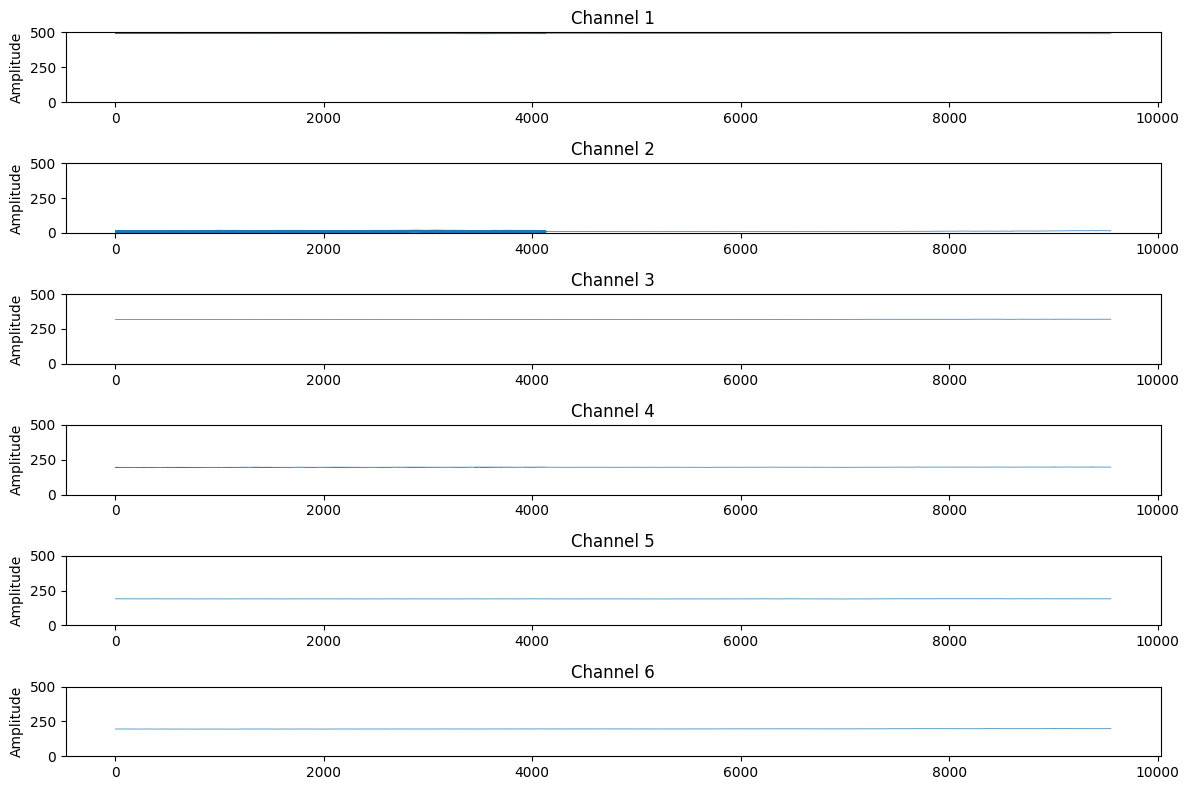

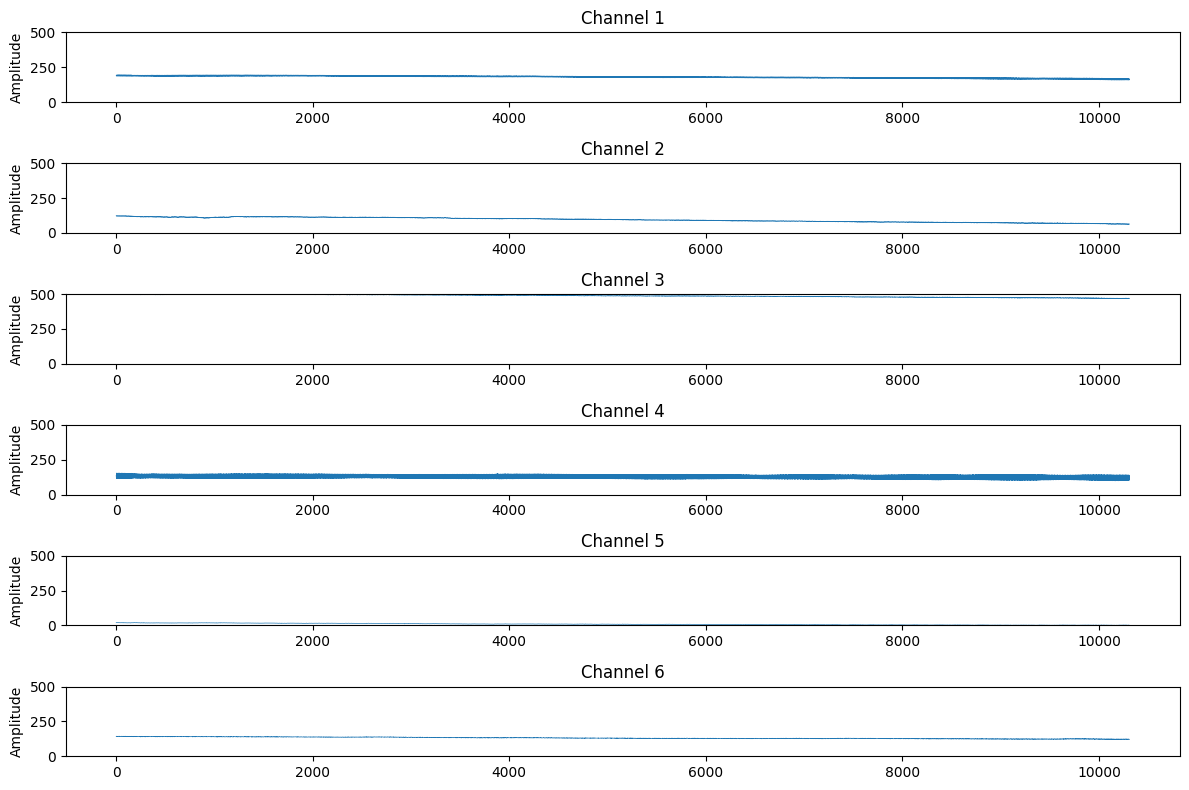

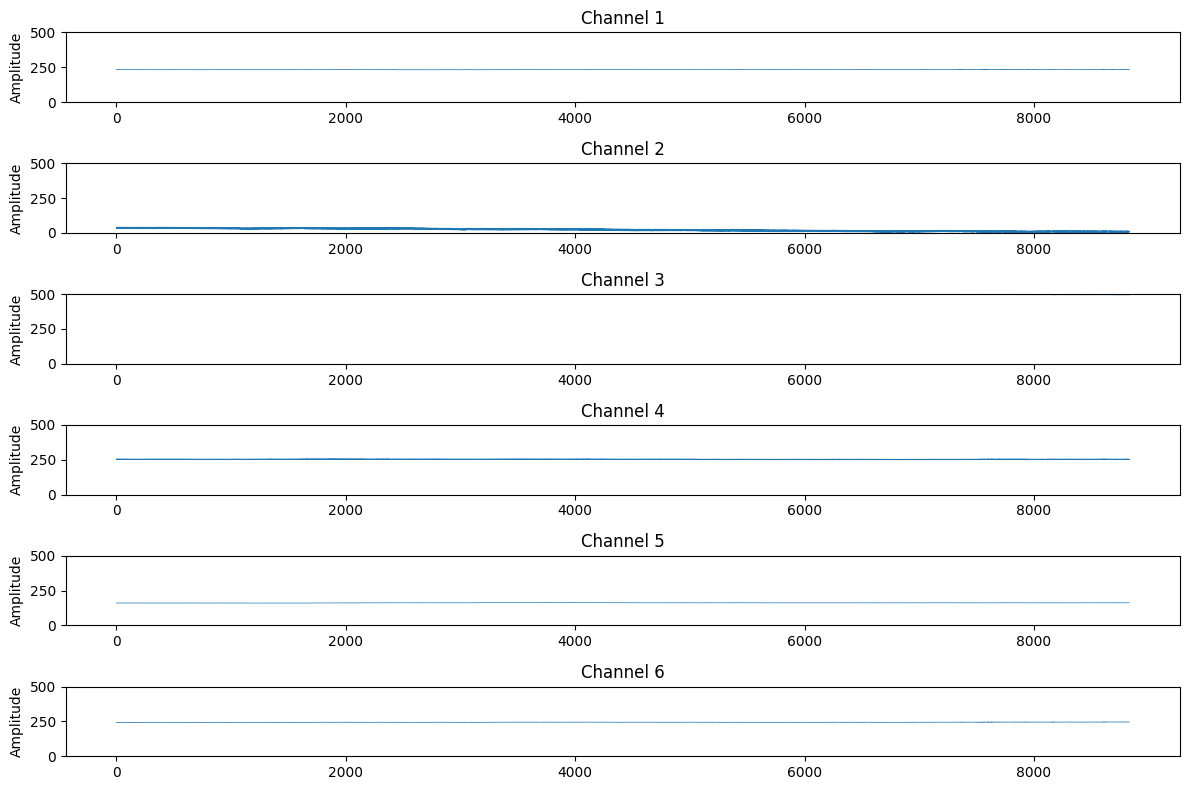

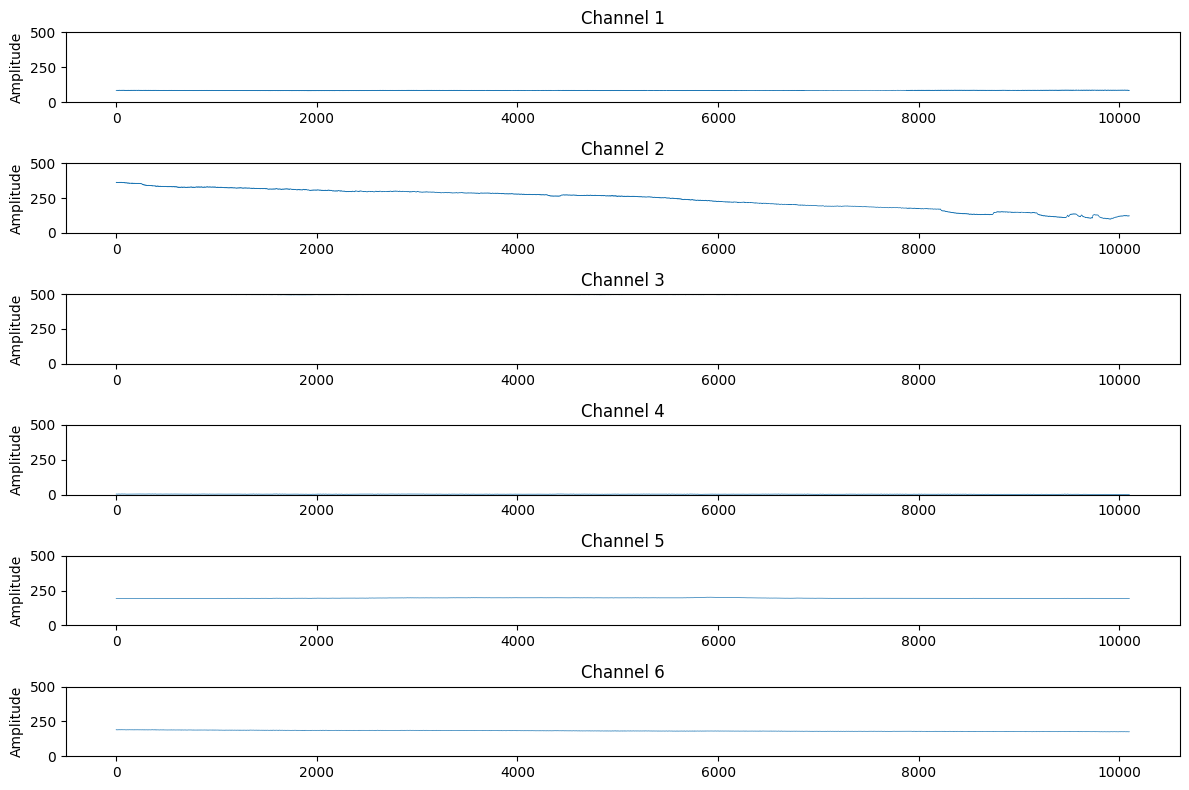

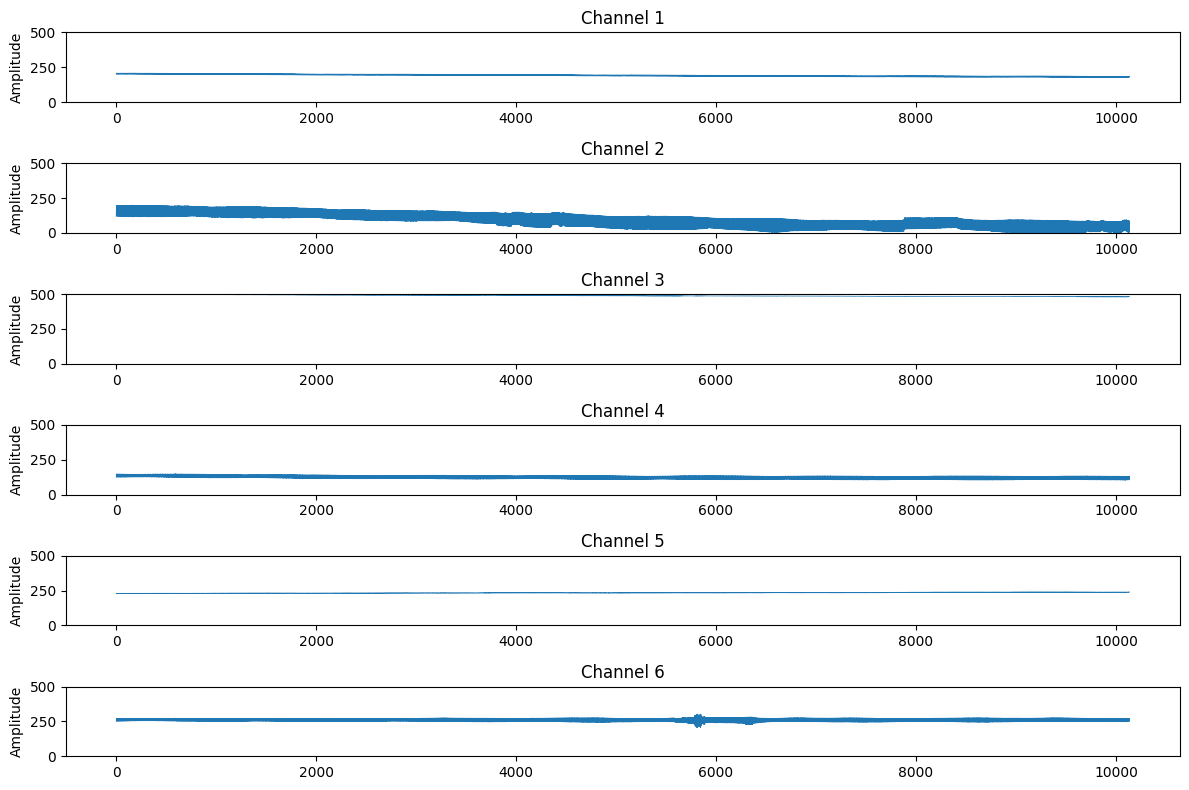

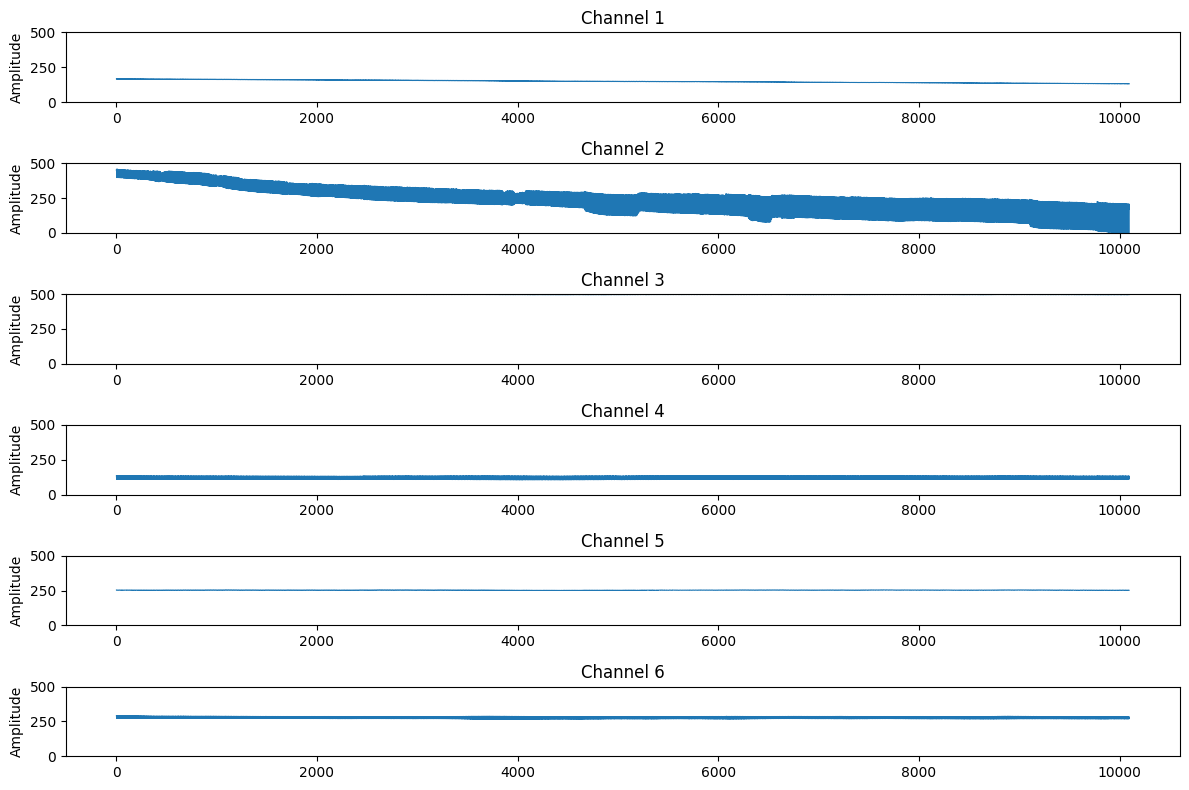

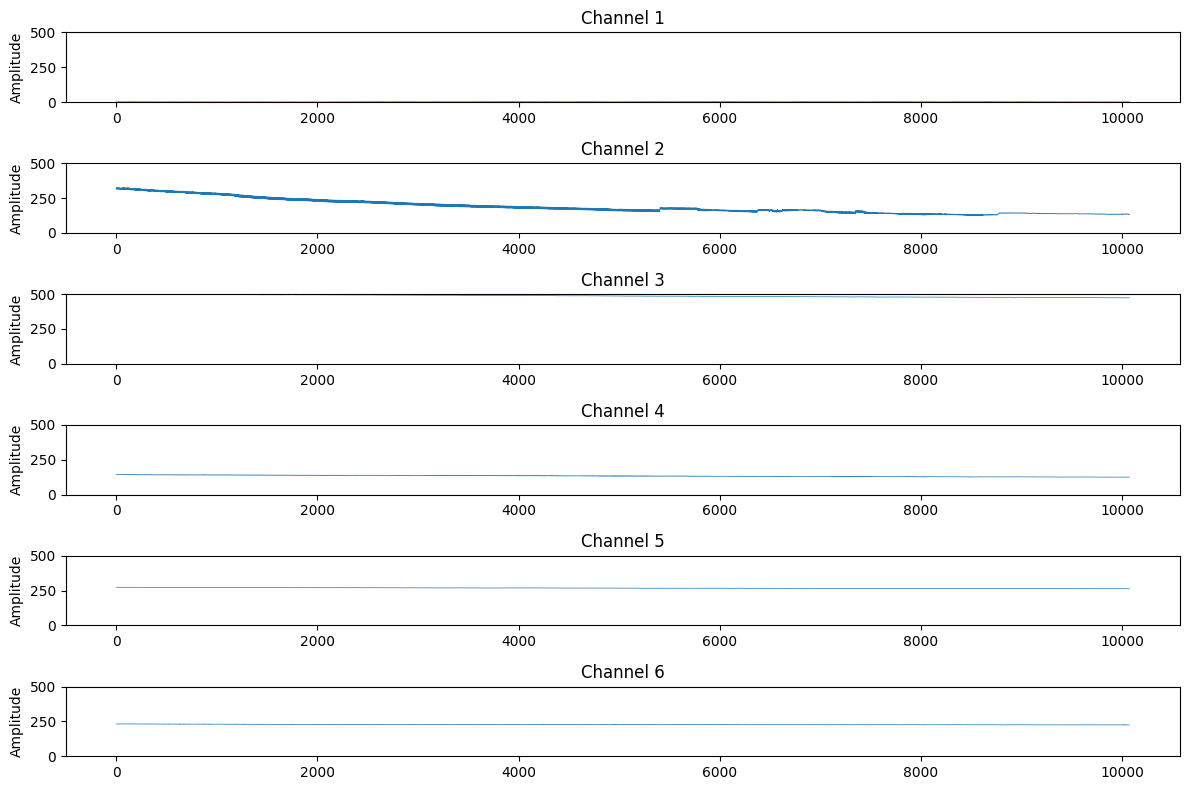

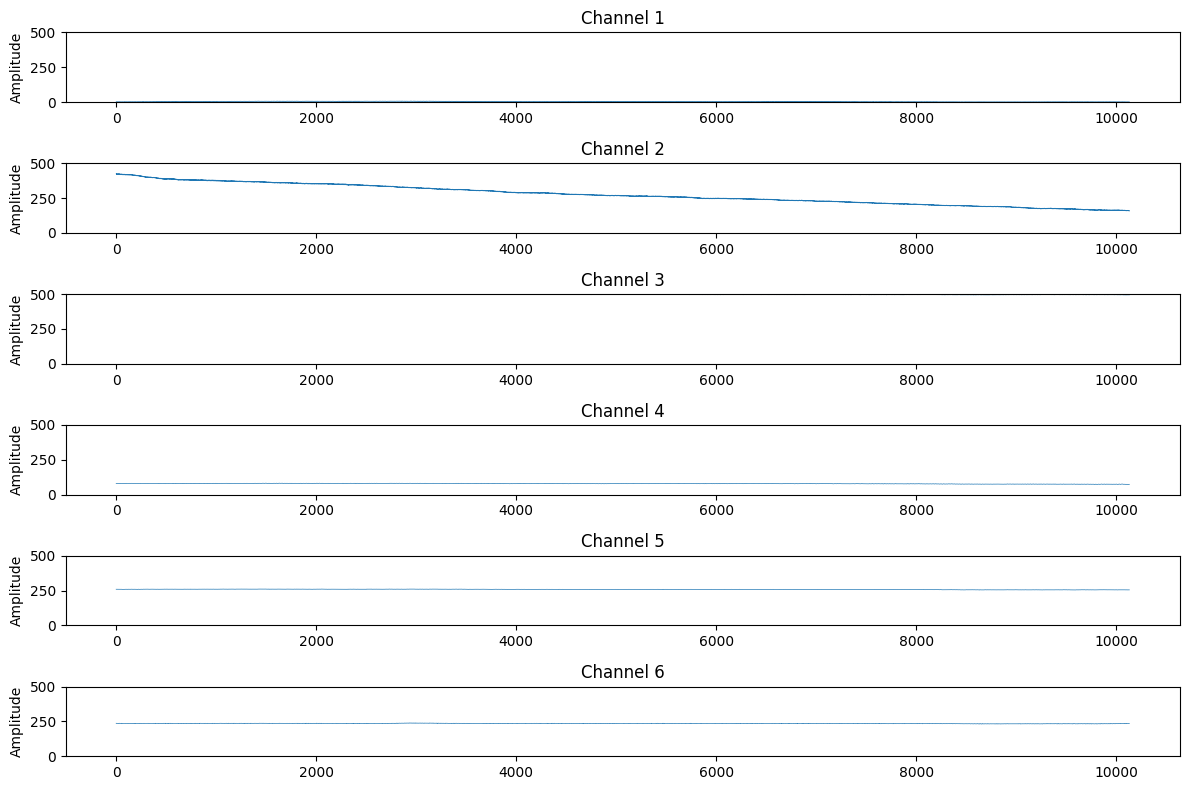

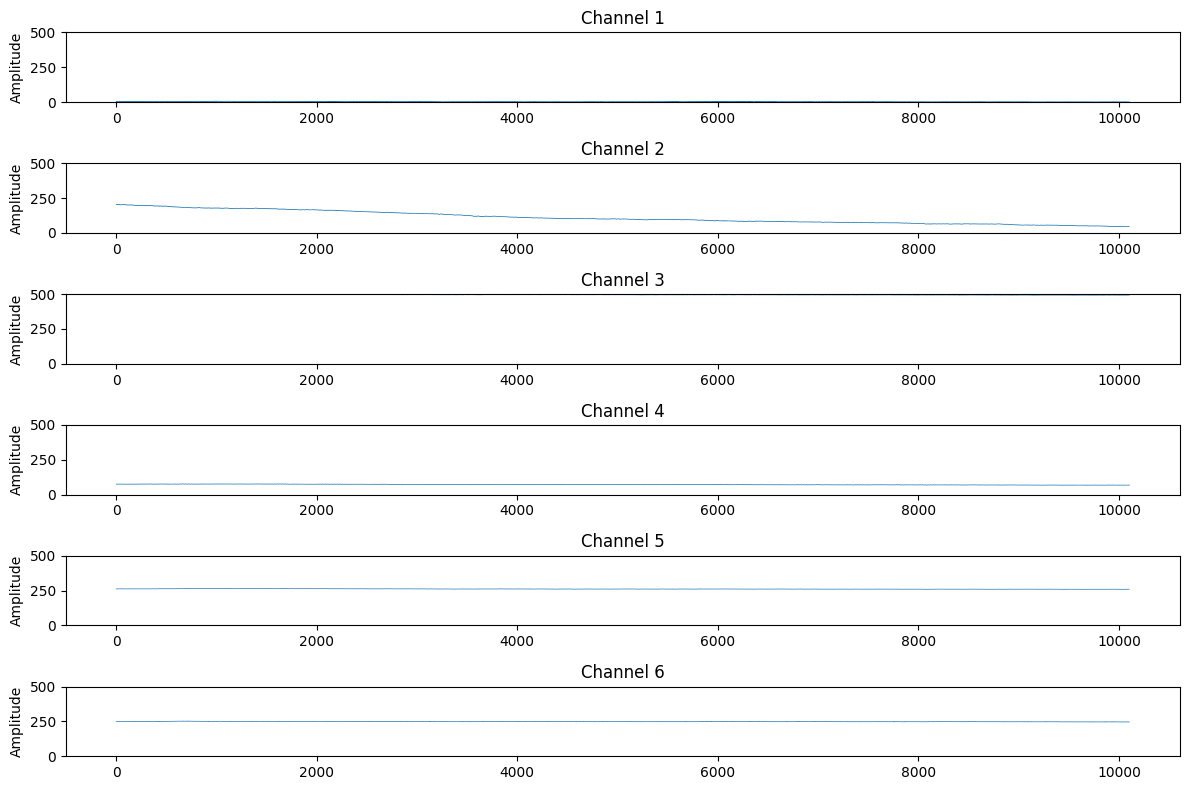

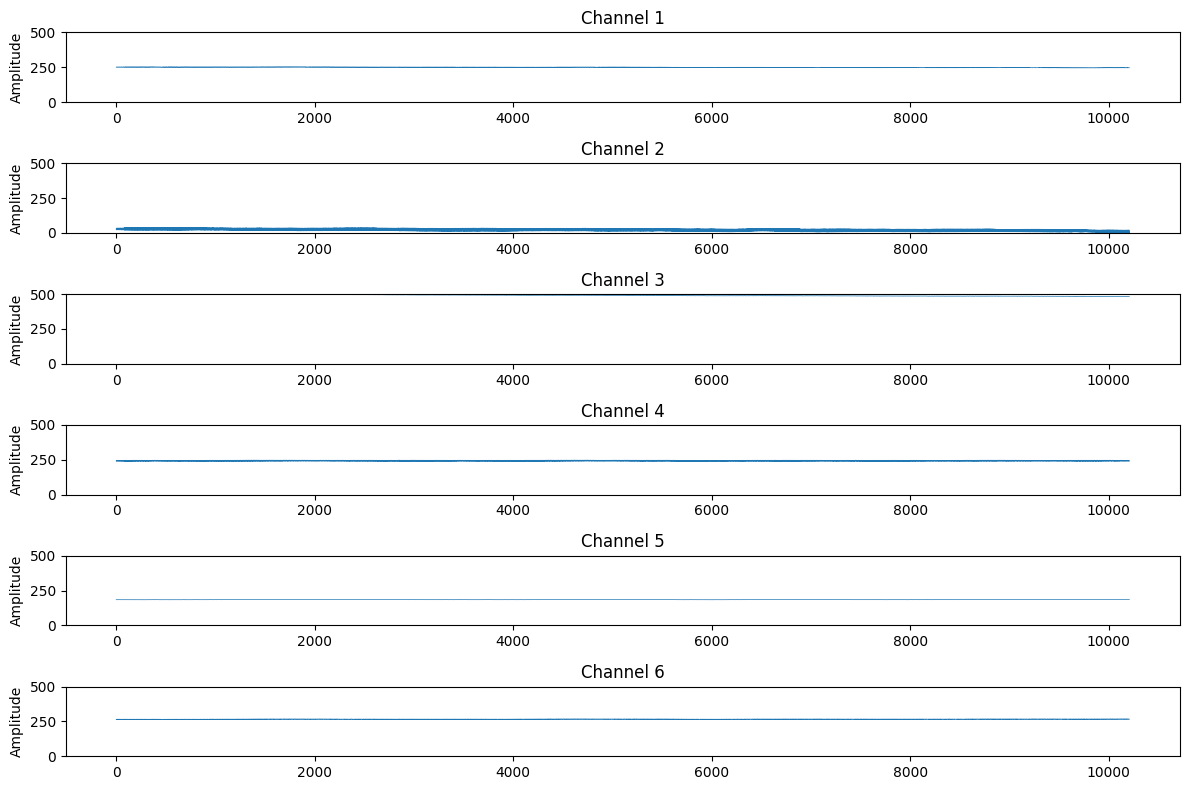

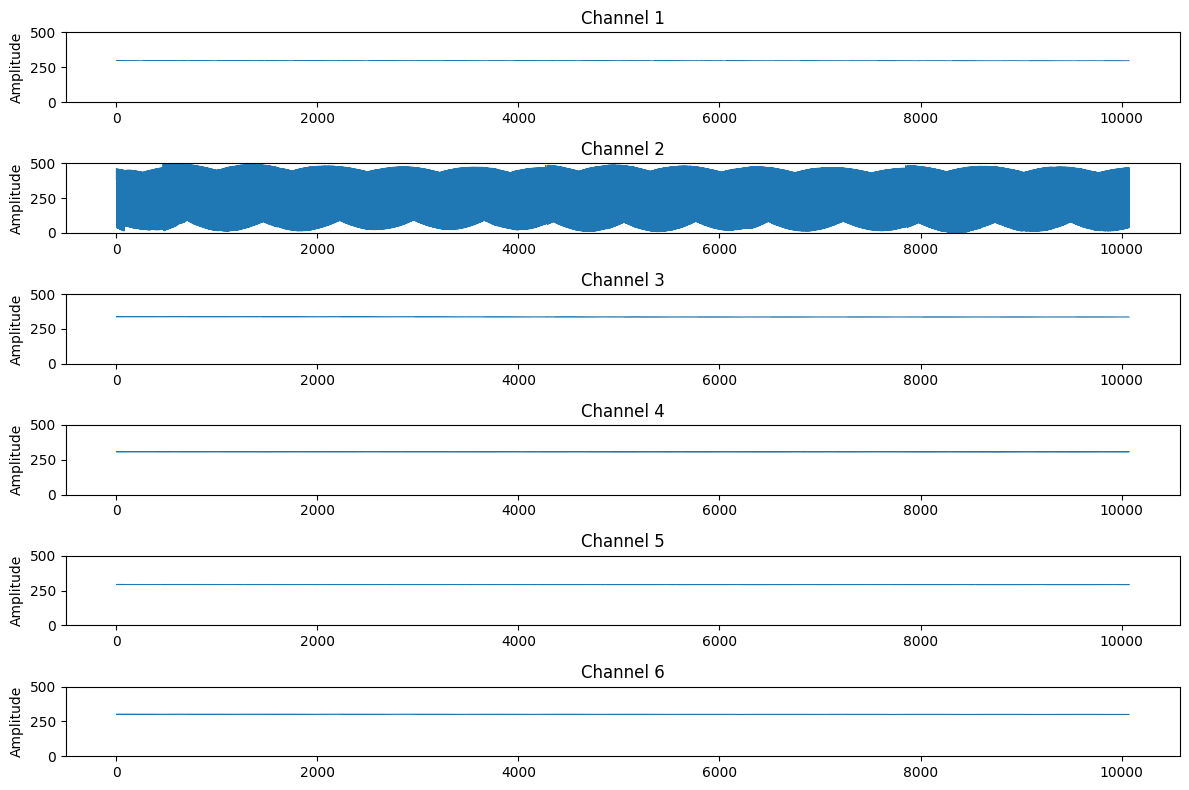

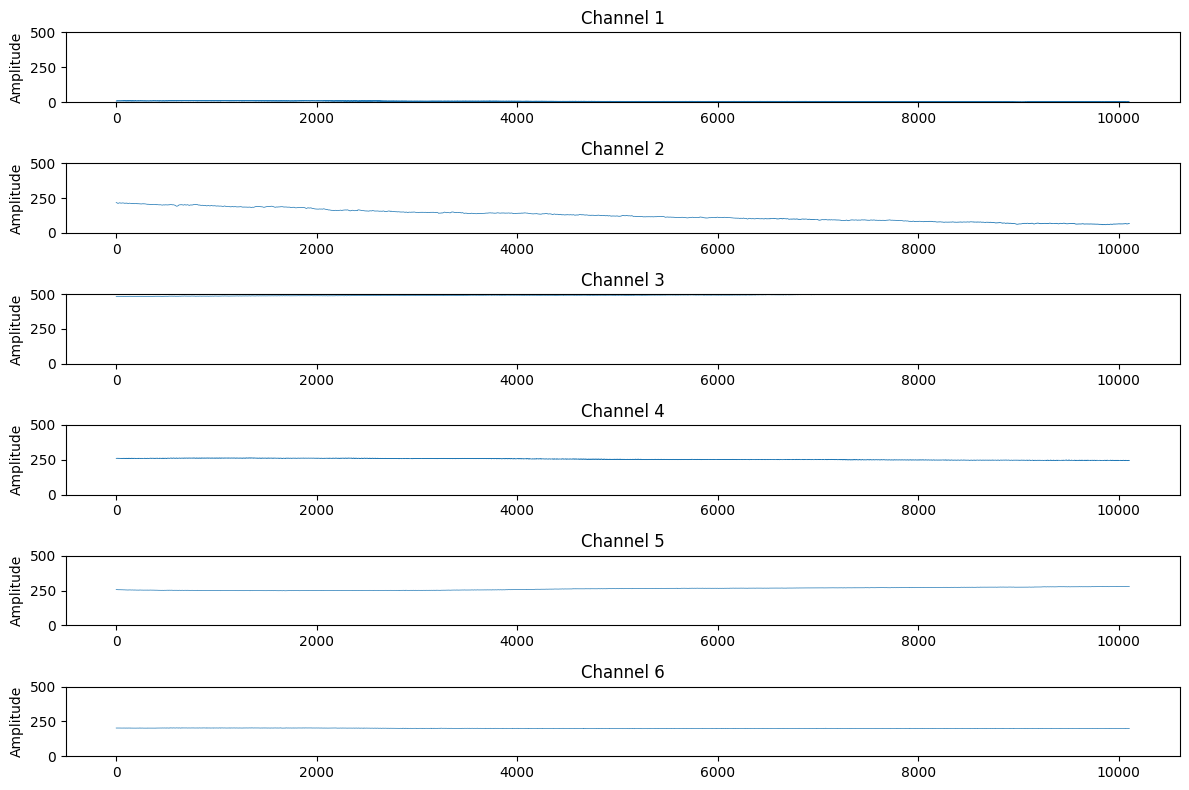

(84, 6, 2500) [3 4 5 6 7 8 9]
(36, 6, 2500) [0 1 2]
Class shape: (120,)
Data shape: (120, 6, 2500)


Creating spectrograms: 100%|██████████| 120/120 [00:02<00:00, 53.85it/s]


In [10]:
def load_eeg_data(file_path, target_range=(0, 500)):
    """Load EEG data from OpenBCI-RAW files and shift to desired range"""
    try:
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np

        # Skip header rows and load only first 6 EEG channels
        data = pd.read_csv(file_path, skiprows=6)
        eeg_data = data.iloc[:, 1:7].values
        
        # Shift and scale EEG data to the desired range
        eeg_min, eeg_max = eeg_data.min(), eeg_data.max()
        scaled_eeg_data = (eeg_data - eeg_min) / (eeg_max - eeg_min)  # Normalize to [0, 1]
        scaled_eeg_data = scaled_eeg_data * (target_range[1] - target_range[0]) + target_range[0]
        
        # Plot the scaled data
        plt.figure(figsize=(12, 8))
        for i in range(6):
            plt.subplot(6, 1, i + 1)
            plt.plot(scaled_eeg_data[:, i], linewidth=0.5)
            plt.title(f'Channel {i + 1}')
            plt.ylim(target_range[0], target_range[1])  # Set y-limits to match the target range
            plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        return scaled_eeg_data
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        # Ensure we have enough data to slice 2500 samples
                        if eeg_data.shape[0] >= 6250:
                            # Extract 2500 samples from each of the 6 channels
                            X.append(eeg_data[3750:6250, :6])  # Assuming 6 channels
                            y.append(subject_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check if we have the desired number of samples
    if X.shape[0] != 36:
        print(f"Warning: Expected 36 samples, but got {X.shape[0]}")
    
    return X, y
    
mat_inputs, mat_targets = load_mat_data('eegdata.mat')
folder_inputs, folder_targets = load_folder_data('dataset')

# Ensure both datasets havl̥e the same number of dimensions
if mat_inputs.ndim == 3 and folder_inputs.ndim == 2:
    folder_inputs = folder_inputs[:, np.newaxis, :]  # Add a new axis to match dimensions

print(mat_inputs.shape,np.unique(mat_targets))

folder_inputs = folder_inputs.transpose(0, 2, 1)
print(folder_inputs.shape,np.unique(folder_targets))
X = np.concatenate((folder_inputs,mat_inputs), axis=0)
y = np.concatenate((folder_targets,mat_targets), axis=0)

# Print class and data shapes
print(f"Class shape: {y.shape}")
print(f"Data shape: {X.shape}")

# Prepare data loaders
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


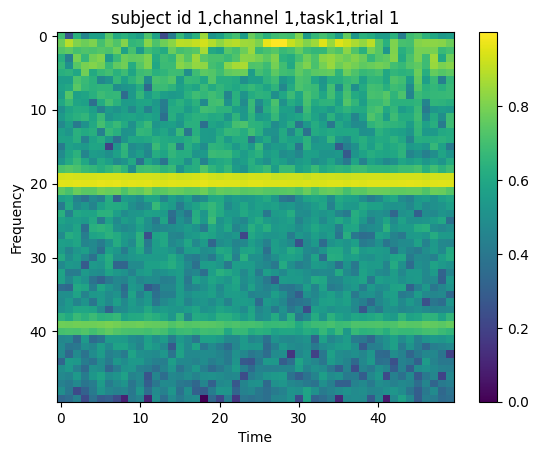

0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [10]:
plt.imshow(create_spectrogram(X[0][0]), aspect='auto', cmap='viridis')
plt.title('subject id 1,channel 1,task1,trial 1')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
print(y[0])
y

In [9]:
# Update dataset creation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use smaller batch size for CPU
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# Train with optimized parameters
num_classes=10
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.5
)

trained_model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=0.001
)



model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.float()
        outputs, _ = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Epoch 1/50:   9%|▉         | 17/180 [00:05<00:50,  3.20it/s, loss=2.2520, acc=19.12%]


KeyboardInterrupt: 